# 1. Buoyancy Frequency Profile

To be in accordance with TEOS-10 it translates from Salinity_[psu] & Temp_[°C] into Absolute_Salinity [g/kg] & Conservative_Temp_deg [°C]. As sources I used the TEOS-10 book, some ChatGPT, lots of StackOverflow or Python Library Documentations (which I can easily quote), and also Work/Study coding experience for which giving sources like "my own memory" isnt feasible.

Precise explanations to be found in the code

## Density Calculation

In [32]:
from pathlib import Path
import numpy as np
import pandas as pd
import gsw

# Paths
UDASH_FILE = Path("UDASH/ArcticOcean_phys_oce_2015.txt")
OUTPUT_DIR = Path("Density")
MISSING_VALUE = -999.0

# CHATGPT: Finding the year within the txt
def _infer_year_from_timestamp(series: pd.Series) -> str:
    """Try to infer a year from the yyyy-mm-ddThh:mm column."""
    s = series.dropna().astype(str)
    if s.empty:
        return "unknown"
    first = s.iloc[0]
    try:
        return str(pd.to_datetime(first).year)
    except Exception:
        return str(first)[:4]

# CHATGPT: Read raw UDASH file
def process_udash_file(path: Path, output_dir: Path = OUTPUT_DIR) -> tuple[pd.DataFrame, Path]:
    df = pd.read_csv(
        path,
        delim_whitespace=True,
        na_values=[MISSING_VALUE],
        engine="python",
    )

    # Replace explicit missing flag just in case
    df = df.replace(MISSING_VALUE, np.nan)

    # Make sure key columns exist
    required_cols = [
        "Prof_no",
        "Cruise",
        "Station",
        "Platform",
        "Type",
        "yyyy-mm-ddThh:mm",
        "Longitude_[deg]",
        "Latitude_[deg]",
        "Pressure_[dbar]",
        "Depth_[m]",
        "Temp_[°C]",
        "Salinity_[psu]",
    ]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in UDASH file: {missing}")

    # Sort so casts stay together and levels are ordered
    sort_keys = [
        "Prof_no",
        "yyyy-mm-ddThh:mm",
        "Depth_[m]",
        "Pressure_[dbar]",
    ]
    sort_keys = [k for k in sort_keys if k in df.columns]
    df = df.sort_values(sort_keys).reset_index(drop=True)

    # TEOS-10 inputs
    SP = df["Salinity_[psu]"].to_numpy(float)
    t = df["Temp_[°C]"].to_numpy(float)
    p = df["Pressure_[dbar]"].to_numpy(float)
    lon = df["Longitude_[deg]"].to_numpy(float)
    lat = df["Latitude_[deg]"].to_numpy(float)

    # ChatGPT: Range-based masking
    def _mask_range(arr, lo, hi):
        bad = (arr < lo) | (arr > hi)
        arr = arr.copy()
        arr[bad] = np.nan
        return arr
    
    # ChatGPT: Range-based masking (only values within masked range)
    lat = _mask_range(lat, -90, 90)
    lon = _mask_range(lon, -180, 360)
    p = _mask_range(p, 0, 12000)
    SP = _mask_range(SP, 0, 50)
    t = _mask_range(t, -5, 40)

    # TEOS-10 computations (Source: TEOS-10 webpage)
    SA = gsw.SA_from_SP(SP, p, lon, lat)           # Absolute salinity [g/kg]
    CT = gsw.CT_from_t(SA, t, p)                   # Conservative temperature [°C]
    rho = gsw.rho(SA, CT, p)                       # In-situ density [kg/m³]
    sigma0 = gsw.sigma0(SA, CT) + 1000.0           # Potential density σ0 + 1000

    # Attach TEOS-10 variables + source_file
    df = df.copy()
    df.insert(0, "source_file", path.name)
    df["Absolute_Salinity_g_kg"] = SA
    df["Conservative_Temp_degC"] = CT
    df["Density_kg_m3"] = rho
    df["Potential_Density_kg_m3"] = sigma0

    # Build output path with year tag
    year = _infer_year_from_timestamp(df["yyyy-mm-ddThh:mm"])
    output_dir.mkdir(parents=True, exist_ok=True)
    out_path = output_dir / f"{year}_{path.stem}_teos10.txt"

    # Choose column order for TEOS-10 file (I prefer to save more rather than less)
    out_cols = [
        "source_file",
        "Prof_no",
        "yyyy-mm-ddThh:mm",
        "Longitude_[deg]",
        "Latitude_[deg]",
        "Pressure_[dbar]",
        "Depth_[m]",
        "Temp_[°C]",
        "Salinity_[psu]",
        "Absolute_Salinity_g_kg",
        "Conservative_Temp_degC",
        "Density_kg_m3",
        "Potential_Density_kg_m3",
    ]
    out_cols = [c for c in out_cols if c in df.columns]

    # Write nicely sorted TEOS-10 file
    df[out_cols].to_csv(
        out_path,
        sep="\t",
        index=False,
        float_format="%.6f",
    )

    print(f"Loaded {len(df)} rows from {path}")
    print(f"TEOS-10 file written to: {out_path}")
    return df, out_path


# EXECUTION
df_teos10, teos10_path = process_udash_file(UDASH_FILE)

# Show a quick preview
df_teos10.head()

/tmp/ipykernel_30095/1123516399.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Loaded 739203 rows from UDASH/ArcticOcean_phys_oce_2015.txt
TEOS-10 file written to: Density/2015_ArcticOcean_phys_oce_2015_teos10.txt


,source_file,Prof_no,Cruise,Station,Platform,Type,yyyy-mm-ddThh:mm,Longitude_[deg],Latitude_[deg],Pressure_[dbar],...,Salinity_[psu],QF.2,Source,DOI,WOD-Cruise-ID,WOD-Cast-ID,Absolute_Salinity_g_kg,Conservative_Temp_degC,Density_kg_m3,Potential_Density_kg_m3
0,ArcticOcean_phys_oce_2015.txt,233,NABOS_2015,AT_001,S,CTD,2015-08-28T09:51,94.8155,82.1627,4.00,...,32.1470,0,iarc,NaN,NaN,NaN,32.299657,-1.571172,1025.880981,1025.861631
1,ArcticOcean_phys_oce_2015.txt,233,NABOS_2015,AT_001,S,CTD,2015-08-28T09:51,94.8155,82.1627,4.99,...,32.1473,0,iarc,NaN,NaN,NaN,32.299956,-1.568981,1025.885959,1025.861820
2,ArcticOcean_phys_oce_2015.txt,233,NABOS_2015,AT_001,S,CTD,2015-08-28T09:51,94.8155,82.1627,5.99,...,32.1466,0,iarc,NaN,NaN,NaN,32.299249,-1.569497,1025.890238,1025.861262
3,ArcticOcean_phys_oce_2015.txt,233,NABOS_2015,AT_001,S,CTD,2015-08-28T09:51,94.8155,82.1627,6.99,...,32.1474,0,iarc,NaN,NaN,NaN,32.300050,-1.569012,1025.895710,1025.861897
4,ArcticOcean_phys_oce_2015.txt,233,NABOS_2015,AT_001,S,CTD,2015-08-28T09:51,94.8155,82.1627,8.00,...,32.1499,0,iarc,NaN,NaN,NaN,32.302558,-1.568630,1025.902611,1025.863914


# Introduce Bathymetry with IBCAO

Sources are https://github.com/gauteh/ibcao_py and https://www.gebco.net/about/committees-and-groups/scrum/ibcao/ibcao-v4

The new QC evaluates each profile against the true local water-column depth from the IBCAO bathymetric grid so that quality is measured relative to the actual physical domain in which internal waves propagate. Because internal-wave modes depend on the vertical extent and stratification of the full water column, a profile’s usefulness is determined by its fractional depth coverage ( 
H_obs/H_true) and by whether its vertical resolution is sufficient to resolve the stratification. Previously, the QC formalism was defined solely through the min-depth as well as the min_distance between individual points. 
Now, the QC  rejects deep-ocean casts that undersample the column while correctly accepting all and finally also shallow-shelf casts that fully resolve their (naturally shallow) environment. 

In [15]:
# IBCAO Bathymetry Loader 

import xarray as xr
import numpy as np
from pathlib import Path

# CHATGPT: You also need pyproj for the coordinate transform:
try:
    from pyproj import Transformer
except ImportError as e:
    raise ImportError(
        "pyproj is required for IBCAO projection.\n"
        "Install it once in a terminal with:  pip install pyproj"
    ) from e

# Path to IBCAO file with warning
BATHY_FILE = Path("IBCAO_v4_200m.nc")

if not BATHY_FILE.exists():
    raise FileNotFoundError(
        f"Bathymetry file not found: {BATHY_FILE}\n"
        "Check the filename/location in your working directory."
    )

ds_bathy = xr.open_dataset(BATHY_FILE)

# IBCAO v4 grid uses x,y (meters) in Polar Stereographic EPSG:3996
coords = list(ds_bathy.coords)
if "x" in coords and "y" in coords:
    x_name, y_name = "x", "y"
else:
    raise KeyError(
        f"Expected 'x' and 'y' coordinates in IBCAO dataset, found {coords}."
    )

# Bathymetry variable: "z" (depth/elevation)
if "z" in ds_bathy.data_vars:
    bathy_var = ds_bathy["z"]
elif "elevation" in ds_bathy.data_vars:
    bathy_var = ds_bathy["elevation"]
else:
    raise KeyError(
        "Could not find bathymetry variable in IBCAO file "
        f"(tried 'z' and 'elevation'). Variables are: {list(ds_bathy.data_vars)}"
    )

# we had to convert it since IBCAU uses x,y in meters isntead of Lat/Lon
# Set up lon/lat (EPSG:4326) is bnased on IBCAO Polar Stereographic (EPSG:3996) transformer
# And "always_xy=True" ensures order is (lon, lat)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3996", always_xy=True)

def get_bottom_depth(lat: float, lon: float) -> float:
    """
    Returns a simple positive bottom depth H_true [m] at given (lat, lon) using IBCAO v4.

    IBCAO convention:
      - bathy_var < 0 : ocean depth 
      - bathy_var > 0 : land elevation

    If the location is on land or outside the grid, returns np.nan.
    """
    # Transform lon/lat to x,y (meters) in EPSG:3996 for IBCAO 
    x_cast, y_cast = transformer.transform(float(lon), float(lat))

    # Nearest-neighbor interpolation as long as QC hold
    z_val = bathy_var.interp(
        {x_name: x_cast, y_name: y_cast},
        method="nearest"
    ).values

    if np.isnan(z_val):
        return np.nan

    # Ocean depths are negative and IBCAO includes both land and sea, so we have to check that
    if z_val < 0:
        return float(-z_val)
    else:
        # Land
        return np.nan


def qc_cast_depth_dependent(depth_array_m, lat, lon):
    """
    Depth-dependent QC per cast.
    Inputs:
        depth_array_m : 1D array of depth values [m]
        lat, lon      : geographic coordinates of cast

    Returns:
        qc_flag           : 3 = good, 2 = acceptable, 1 = poor
        coverage          : H_obs / H_true
        max_gap_observed  : largest vertical gap within the cast
        H_true            : bottom depth from bathymetry
    """
    depth_array_m = np.asarray(depth_array_m, dtype=float)
    depth_array_m = depth_array_m[np.isfinite(depth_array_m)]

    # We need enough probes
    if depth_array_m.size < 2:
        return 1, np.nan, np.nan, np.nan

    depths = np.sort(depth_array_m)
    H_obs = float(depths.max())

    # Call previous fct that gets the bathymetry depths
    H_true = get_bottom_depth(lat, lon)

    # Handle missing bathymetry by just saying its 1 (real bathymetry could never be fully 1)
    if not np.isfinite(H_true) or H_true <= 0:
        H_true = H_obs
        coverage = 1.0
    else:
        coverage = H_obs / H_true

    # Largest vertical gap
    gaps = np.diff(depths)
    max_gap_observed = float(np.nanmax(gaps)) if gaps.size > 0 else 0.0

    # Depth-dependent allowed gap:
    max_gap_allowed = min(50.0, 0.25 * H_true)

    # QC logic
    if coverage >= 0.80 and max_gap_observed <= max_gap_allowed:
        qc_flag = 3  # good
    elif coverage >= 0.50:
        qc_flag = 2  # acceptable
    else:
        qc_flag = 1  # poor

    return qc_flag, coverage, max_gap_observed, H_true



## Buoyancy Calculation

From the just calculated density I here now calculate the buoyancy profile for all the casts in a given year.


Specifically the years 2000, 2003, 2004, 2006 and 2008 caused small (less then 10 points per year out of more than 4000 casts per year) issues with the exact same code that worked well for literally every single other year.

2012 has by far the most casts with 9593.

/home/conda/envs/ocean/lib/python3.11/site-packages/gsw/stability.py:86: RuntimeWarning: divide by zero encountered in divide
  N2 = ((g_local**2) / (specvol_mid * db_to_pa * dp))


In [84]:
from pathlib import Path
import numpy as np
import pandas as pd
import gsw

# Path
UDASH_FILE = Path("UDASH/ArcticOcean_phys_oce_2015.txt")
TEOS_DIR = Path("Density")
N2_DIR = Path("N2")

# CHATGPT: Find the TEOS-10 file produced earlier (For some reason I can never grasp how to retrieve paths...)
pattern = f"*_{UDASH_FILE.stem}_teos10.txt"
teos_files = sorted(TEOS_DIR.glob(pattern))
if not teos_files:
    raise FileNotFoundError(f"No TEOS-10 file matching {pattern} in {TEOS_DIR}")
TEOS10_FILE = teos_files[0]

# Load TEOS-10 data
df = pd.read_csv(TEOS10_FILE, sep="\t")

def compute_N2_for_cast(g: pd.DataFrame) -> pd.DataFrame | None:
    """
    Compute N2 for a single cast, keeping metadata and QC (quality control parameters).

    QC includes:
      - Chelton style overwriting of negative N2
      - Depth range of the profile
      - Maximum vertical gap introduction for the gridding
      - Quality flag N2_QC_flag:
          0 = poor (too shallow / very gappy (as defined from the QC thresholds))
          1 = acceptable (depth range >= MIN_DEPTH_RANGE_OK)
          2 = good (depth range >= MIN_DEPTH_RANGE_GOOD and max gap <= MAX_GAP_GOOD)
    """
    # sort after pressure per cast
    g = g.sort_values("Pressure_[dbar]").dropna(
        subset=["Absolute_Salinity_g_kg", "Conservative_Temp_degC",
                "Density_kg_m3", "Pressure_[dbar]", "Latitude_[deg]", "Longitude_[deg]"]
    )
    if len(g) < 3:
        return None

    # gsw only takes floating point numbers
    SA = g["Absolute_Salinity_g_kg"].to_numpy(float)
    CT = g["Conservative_Temp_degC"].to_numpy(float)
    p = g["Pressure_[dbar]"].to_numpy(float)
    rho = g["Density_kg_m3"].to_numpy(float)
    lat = float(g["Latitude_[deg]"].iloc[0])
    lon = float(g["Longitude_[deg]"].iloc[0])

    # N2 and mid-pressure as gsw is defined (as in Pinner et al 2025)
    N2_raw, p_mid = gsw.Nsquared(SA, CT, p, lat)
    if N2_raw.size == 0:
        return None

    # as in Chelton et al 1998
    # negative N2(z_k) → N2(z_{k-1}); if shallowest N2(z_1) < 0 → 1e-8
    N2_fixed = N2_raw.copy()
    for k in range(len(N2_fixed)):
        if N2_fixed[k] < 0:
            if k == 0:
                N2_fixed[k] = 1e-8  # s^-2 at shallowest level
            else:
                N2_fixed[k] = N2_fixed[k - 1]
    N2 = N2_fixed

    # depth and mid-point variables (as in Pinner et al 2025) because gsw uses midpoint depths
    z_mid = -gsw.z_from_p(p_mid, lat)  # positive definitive depth
    SA_mid = 0.5 * (SA[:-1] + SA[1:])
    CT_mid = 0.5 * (CT[:-1] + CT[1:])
    rho_mid = 0.5 * (rho[:-1] + rho[1:])

    """
    QC metrics: depth range, max vertical gap, number of levels
    
    What makes a good quality result? The positive definitiveness of N2 is already ensured. For plotting purposes it is benefitial
    have data in regular, reasnable distances which are somewhat evenly spaced, dont vary too much in amount of levels between
    individual casts. The spatial (lat-lon) relation shall not be considered here, as we want to have variation in that realm. 
    
    Large values of N2 shall further not be incorporated either, as they might highlight patterns or measurement errors.
    """
    if z_mid.size > 0:
        depth_range = float(z_mid.max() - z_mid.min())
    else:
        depth_range = 0.0

    if z_mid.size > 1:
        dz = np.diff(z_mid)
        max_gap = float(np.max(dz))
    else:
        dz = np.array([])
        max_gap = np.nan

    n_levels = int(z_mid.size)

    # New: depth-dependent QC (IBCAO), then mapped to 0/1/2 scale
    qc_flag = 0
    qc_dep, coverage, max_gap_dep, H_true = qc_cast_depth_dependent(
        depth_array_m=z_mid,
        lat=lat,
        lon=lon,
    )
    if qc_dep == 3:
        qc_flag = 2  # good
    elif qc_dep == 2:
        qc_flag = 1  # acceptable
    else:
        qc_flag = 0  # poor

    # construct columns again
    first = g.iloc[0]
    return pd.DataFrame({
        "source_file": first["source_file"],
        "Prof_no": first["Prof_no"],
        "yyyy-mm-ddThh:mm": first["yyyy-mm-ddThh:mm"],
        "Longitude_[deg]": first["Longitude_[deg]"],
        "Latitude_[deg]": first["Latitude_[deg]"],
        "Pressure_[dbar]": p_mid,
        "Depth_[m]": z_mid,
        "Absolute_Salinity_[g/kg]": SA_mid,
        "Conservative_Temperature_[°C]": CT_mid,
        "In-situ_Density_[kg m^-3]": rho_mid,
        "N2_[s^-2]": N2,
        "Depth_range_[m]": depth_range,
        "Max_gap_[m]": max_gap,
        "N_levels": n_levels,
        "N2_QC_flag": qc_flag,
        "H_true_bathymetry_[m]": H_true,
        "Coverage_fraction": coverage,
        "Max_gap_depthdep_[m]": max_gap_dep,
    })

# Compute N2 for all casts
pieces = []
for pid, gcast in df.groupby("Prof_no"):
    out = compute_N2_for_cast(gcast)
    if out is not None:
        pieces.append(out)

# Error message so as not to just get a Python error
if not pieces:
    raise RuntimeError("No valid casts for N² computation.")

dfN2 = pd.concat(pieces, ignore_index=True)

# Ensure sorting: by profile, then depth, then pressure
dfN2 = dfN2.sort_values(
    ["Prof_no", "Depth_[m]", "Pressure_[dbar]"]
).reset_index(drop=True)

# Make QC diagnostic columns readable by explicitly NOT writing them exponentially

dfN2["H_true_bathymetry_[m]"] = dfN2["H_true_bathymetry_[m]"].round(1)
dfN2["Coverage_fraction"] = dfN2["Coverage_fraction"].round(3)
dfN2["Max_gap_depthdep_[m]"] = dfN2["Max_gap_depthdep_[m]"].round(1)

# Save output
N2_DIR.mkdir(parents=True, exist_ok=True)
year_tag = TEOS10_FILE.stem.split("_", 1)[0]
out_path = N2_DIR / f"N2_{year_tag}_{UDASH_FILE.stem}.txt"

cols_out = [
    "source_file",
    "Prof_no",
    "yyyy-mm-ddThh:mm",
    "Longitude_[deg]",
    "Latitude_[deg]",
    "Pressure_[dbar]",
    "Depth_[m]",
    "Absolute_Salinity_[g/kg]",
    "Conservative_Temperature_[°C]",
    "In-situ_Density_[kg m^-3]",
    "N2_[s^-2]",
    "Depth_range_[m]",
    "Max_gap_[m]",
    "N_levels",
    "N2_QC_flag",
    "H_true_bathymetry_[m]",
    "Coverage_fraction",
    "Max_gap_depthdep_[m]",
]
cols_out = [c for c in cols_out if c in dfN2.columns]

# only format N2 column in scientific notation (I think I dont need that, but idk)
df_out = dfN2[cols_out].copy()

df_out["N2_[s^-2]"] = df_out["N2_[s^-2]"].apply(lambda x: f"{x:.6e}")

# Save to file
df_out.to_csv(
    out_path,
    sep="\t",
    index=False,
)

print(f"Computed N² for {dfN2['Prof_no'].nunique()} casts "
      f"({len(dfN2)} midpoints).")
print(f"N² file written to: {out_path}")

dfN2.head()


Computed N² for 1835 casts (735159 midpoints).
N² file written to: N2/N2_2015_ArcticOcean_phys_oce_2015.txt


,source_file,Prof_no,yyyy-mm-ddThh:mm,Longitude_[deg],Latitude_[deg],Pressure_[dbar],Depth_[m],Absolute_Salinity_[g/kg],Conservative_Temperature_[°C],In-situ_Density_[kg m^-3],N2_[s^-2],Depth_range_[m],Max_gap_[m],N_levels,N2_QC_flag,H_true_bathymetry_[m],Coverage_fraction,Max_gap_depthdep_[m]
0,ArcticOcean_phys_oce_2015.txt,233,2015-08-28T09:51,94.8155,82.1627,4.495,4.447125,32.299807,-1.570076,1025.883470,0.000002,2222.19959,6.853198,2241,2,2238.1,0.995,6.9
1,ArcticOcean_phys_oce_2015.txt,233,2015-08-28T09:51,94.8155,82.1627,5.490,5.431514,32.299603,-1.569239,1025.888099,0.000002,2222.19959,6.853198,2241,2,2238.1,0.995,6.9
2,ArcticOcean_phys_oce_2015.txt,233,2015-08-28T09:51,94.8155,82.1627,6.490,6.420845,32.299650,-1.569254,1025.892974,0.000006,2222.19959,6.853198,2241,2,2238.1,0.995,6.9
3,ArcticOcean_phys_oce_2015.txt,233,2015-08-28T09:51,94.8155,82.1627,7.495,7.415118,32.301304,-1.568821,1025.899161,0.000019,2222.19959,6.853198,2241,2,2238.1,0.995,6.9
4,ArcticOcean_phys_oce_2015.txt,233,2015-08-28T09:51,94.8155,82.1627,8.500,8.409387,32.303410,-1.568388,1025.905712,0.000013,2222.19959,6.853198,2241,2,2238.1,0.995,6.9


# Example Buoyancy Profile

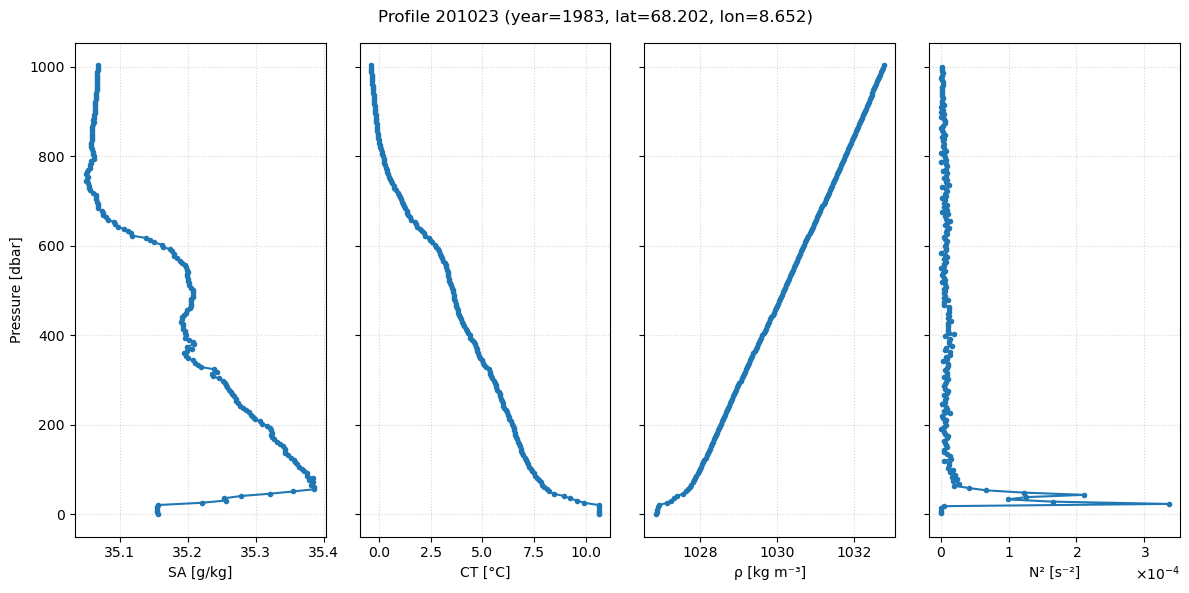

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from pathlib import Path


year = 1983            
profile_id = 201023       

# Load UDASH file for that year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
TEOS_DIR = Path("Density")

# CHATGPT: ensures you get the correct TEOS-10 file associated with the UDASH file by searching for a pattern
pattern_teos = f"*_{UDASH_FILE.stem}_teos10.txt"
teos_files = sorted(TEOS_DIR.glob(pattern_teos))
if not teos_files:
    raise FileNotFoundError(f"No TEOS-10 file matching {pattern_teos}")

TEOS10_FILE = teos_files[0]
df_teos10 = pd.read_csv(TEOS10_FILE, sep="\t")

# CHATGPT: Load N2 file for that year the same way like the TEOS-10 file
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"
if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Select the chosen cast from both files
g_teos = (
    df_teos10[df_teos10["Prof_no"] == profile_id]
    .sort_values("Pressure_[dbar]")
)

g_n2 = (
    dfN2[dfN2["Prof_no"] == profile_id]
    .sort_values("Pressure_[dbar]")
)

# Give a warning if one file doesnt have that cast
if g_teos.empty:
    raise RuntimeError(f"Cast {profile_id} not found in TEOS-10 file for year {year}")

if g_n2.empty:
    raise RuntimeError(f"Cast {profile_id} not found in N2 file for year {year}")

# Extract variables and make them into float agsin
p = g_teos["Pressure_[dbar]"].to_numpy()
SA = g_teos["Absolute_Salinity_g_kg"].to_numpy()
CT = g_teos["Conservative_Temp_degC"].to_numpy()
rho = g_teos["Density_kg_m3"].to_numpy()

p_mid = g_n2["Pressure_[dbar]"].to_numpy()
N2v = g_n2["N2_[s^-2]"].to_numpy()

# Plot
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

axes[0].plot(SA, p, marker=".")
axes[0].set_xlabel("SA [g/kg]")
axes[0].set_ylabel("Pressure [dbar]")

axes[1].plot(CT, p, marker=".")
axes[1].set_xlabel("CT [°C]")

axes[2].plot(rho, p, marker=".")
axes[2].set_xlabel("ρ [kg m⁻³]")

axes[3].plot(N2v, p_mid, marker=".")
axes[3].set_xlabel("N² [s⁻²]")

# I prefer scientific notation for the buoyancy frequencies
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
axes[3].xaxis.set_major_formatter(formatter)
axes[3].ticklabel_format(style="sci", axis="x", scilimits=(0, 3))

# Inverts the axis because pressure and depth are inversely related
for ax in axes:
    ax.invert_yaxis()
    ax.grid(True, linestyle=":", alpha=0.5)

# Lat & Lon of the FIRST measurement per cast
lat = g_teos["Latitude_[deg]"].iloc[0]
lon = g_teos["Longitude_[deg]"].iloc[0]

fig.suptitle(
    f"Profile {profile_id} (year={year}, lat={lat:.3f}, lon={lon:.3f})",
    y=0.98
)

plt.tight_layout()
plt.show()


For one cast (one Prof_no) this code takes the mid-point depths and N2 from dfN2 (Depth_[m], N2_[s^-2] for that Prof_no and year), then does a check to only proceed if N2_QC_flag is at least 1 or 2.

Afterwards I define a regular depth grid (e.g. Δz = 5–10 m or the median native Δz) which I can simply adapt on the go.

Finally to interpolate N2(z) from the irregular z_mid to the regular z_reg, so as not only to have the pressure plot as above.

Preparing cast Prof_no=133745 (year=2010) for EVP
  N2_QC_flag = 2, depth_range = 3293.9 m, max_gap = 1.4 m
  Regular grid: 3300 levels, dz ≈ 1.00 m
  Time: 2010-07-13 18:22:00  (month=7)


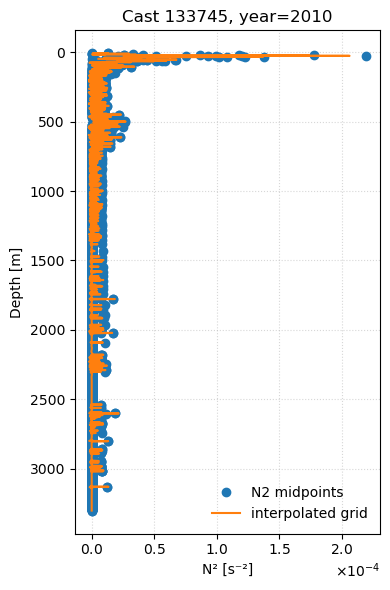

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import ScalarFormatter



year = 2010           # year of interest
profile_id = 133745      # Prof_no to prepare for EVP
dz_target = None      # if None -> use median native Δz; else set as one likes

# Load N2 file for that year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"

# Error if that file doesnt exit
if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Cast out the non-casted casts to keep the casted cast
g = (
    dfN2[dfN2["Prof_no"] == profile_id]
    .sort_values("Depth_[m]")
    .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
)

# Cast-check the cast table. If the casted cast is castless, cast a RuntimeError for the cast-year.
if g.empty:
    raise RuntimeError(f"Cast {profile_id} not found in N2 file for year {year}")

# QC info since it´s best to just ignore the 0´s
qc_flag = g["N2_QC_flag"].iloc[0] if "N2_QC_flag" in g.columns else np.nan
depth_range = g["Depth_range_[m]"].iloc[0] if "Depth_range_[m]" in g.columns else np.nan
max_gap = g["Max_gap_[m]"].iloc[0] if "Max_gap_[m]" in g.columns else np.nan

print(f"Preparing cast Prof_no={profile_id} (year={year}) for EVP")
print(f"  N2_QC_flag = {qc_flag}, depth_range = {depth_range:.1f} m, max_gap = {max_gap:.1f} m")

# Native mid-point depth and N2 to float
z_mid = g["Depth_[m]"].to_numpy(float)
N2_mid = g["N2_[s^-2]"].to_numpy(float)

# Ensure we have enough levels per cast to yield a physically meaningful profile
if z_mid.size < 3:
    raise RuntimeError("Too few N² levels to build a useful regular grid.")

# Define regular depth grid from the mid-depths as is intrinsic to Chelton and the gsw function
dz_native = np.diff(z_mid)
dz_med = float(np.median(dz_native)) if dz_native.size > 0 else np.nan

# Define substitution seperation
if dz_target is None:
    dz = dz_med
else:
    dz = float(dz_target)

if not np.isfinite(dz) or dz <= 0:
    raise RuntimeError(f"Could not determine a positive dz (dz_native_med = {dz_med})")

zmin, zmax = float(z_mid.min()), float(z_mid.max())
z_reg = np.arange(zmin, zmax + 0.5 * dz, dz)  # include top & bottom

# Interpolate N2 onto regular grid how I learned it
#N2_reg = np.interp(z_reg, z_mid, N2_mid)

# CHATGPT
# Interpolate N2 onto regular grid with a smooth spline
# s = 0 -> passes exactly through the data (already much smoother than np.interp)
# increase s for more smoothing, e.g. s=len(z_mid)*np.var(N2_mid)*0.1
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(z_mid, N2_mid, s=0.000000005)
N2_reg = spline(z_reg)


# Grab metadata (lat, lon, time, month) from the first part of the cast
lat = float(g["Latitude_[deg]"].iloc[0])
lon = float(g["Longitude_[deg]"].iloc[0])

cast_time = None
cast_month = None
if "yyyy-mm-ddThh:mm" in g.columns:
    try:
        cast_time = pd.to_datetime(g["yyyy-mm-ddThh:mm"].iloc[0])
        cast_month = cast_time.month
    except Exception:
        pass

print(f"  Regular grid: {z_reg.size} levels, dz ≈ {dz:.2f} m")
if cast_month is not None:
    print(f"  Time: {cast_time}  (month={cast_month})")

# Quick diagnostic plot: pointwise vs interpolated N2
fig, ax = plt.subplots(figsize=(4, 6))

ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 2))

ax.plot(N2_mid, z_mid, "o", label="N2 midpoints")
ax.plot(N2_reg, z_reg, "-", label="interpolated grid")
ax.invert_yaxis()
ax.set_xlabel("N² [s⁻²]")
ax.set_ylabel("Depth [m]")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(frameon=False)
ax.set_title(f"Cast {profile_id}, year={year}")

plt.tight_layout()
plt.show()

# z_reg and N2_reg are now ready for EVP (Step 4–5)


I am thinking that an uncertainty calculation is needed due to the error propagation. Perhaps the MAD-based Method found in the Git Repository of Pollmann et.al. can be adapted to this here?

It is furthermore worthwile to retrieve an overall profile for a given year, despite seasonal variations, just to make sure it overall behaves somewhat physical.

# Upper Meters
For now I decided to keep the upper meters included in the profiles, especially since excluding them would just mean slight changes in the buoyancy calculation cell and interpolation cell. At least thats what I believe prior to having done that! :)

Year 2010: 5356 casts with N2_QC_flag >= 2
Included 5356 casts in the average profile.


/tmp/ipykernel_28586/533555326.py:74: RuntimeWarning: Mean of empty slice
  mean_N2 = np.nanmean(N2_stack, axis=0)
/home/conda/envs/ocean/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


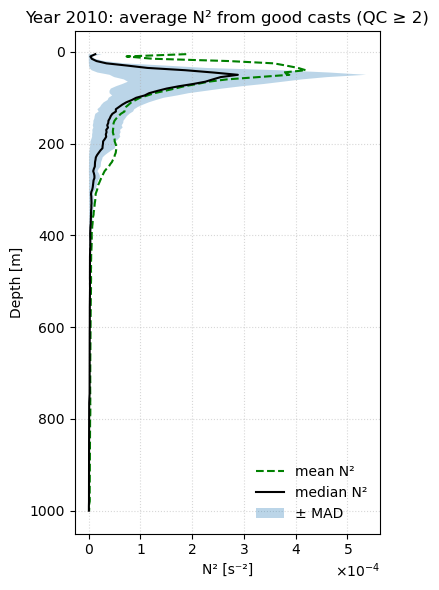

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


# SETTINGS
year = 2010           
qc_min = 2            # minimum N2_QC_flag to accept
z_min = 0.0           # depth range for common grid [m]
z_max = 1000.0         
dz = 5.0              # grid spacing [m]

# Load N2 file for given year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"

# Again, integrating an error message is always better than relaying on Python error messages
if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Select "good" casts by QC flag
if "N2_QC_flag" not in dfN2.columns:
    raise RuntimeError("Column 'N2_QC_flag' not found. "
                       "Make sure you ran the QC-aware N² cell.")

# Copy the good casts
good = dfN2[dfN2["N2_QC_flag"] >= qc_min].copy()
if good.empty:
    raise RuntimeError(f"No casts with N2_QC_flag >= {qc_min} for year {year}.")

# Retain the approved cast id´s
cast_ids = good["Prof_no"].unique()
print(f"Year {year}: {len(cast_ids)} casts with N2_QC_flag >= {qc_min}")

# Build common depth grid at the midpoints
z_grid = np.arange(z_min, z_max + dz/2, dz)
nz = z_grid.size

# Matrix to hold N2(z) per cast on common grid
N2_stack = []

# Loop that checks each N2 wether it is in an approved cast and then turns it into float
for cid in cast_ids:
    g = (
        good[good["Prof_no"] == cid]
        .sort_values("Depth_[m]")
        .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
    )
    if g.empty or g["Depth_[m]"].nunique() < 3:
        continue

    z_mid = g["Depth_[m]"].to_numpy(float)
    N2_mid = g["N2_[s^-2]"].to_numpy(float)

# interpolate to z_grid and set values outside native range to NaN
    z_lo, z_hi = z_mid.min(), z_mid.max()
    N2_interp = np.interp(z_grid, z_mid, N2_mid)
    mask_outside = (z_grid < z_lo) | (z_grid > z_hi)
    N2_interp[mask_outside] = np.nan

    N2_stack.append(N2_interp)

# We cant interpolate if there is nothing to interpolate
N2_stack = np.array(N2_stack)
if N2_stack.size == 0:
    raise RuntimeError("No valid casts for interpolation on common grid.")

print(f"Included {N2_stack.shape[0]} casts in the average profile.")

# Compute average profiles (mean, median, MAD) as in Pinner et al 2025
mean_N2 = np.nanmean(N2_stack, axis=0)
median_N2 = np.nanmedian(N2_stack, axis=0)
mad_N2 = np.nanmedian(np.abs(N2_stack - median_N2), axis=0)

# Plot average N2 profiles
fig, ax = plt.subplots(figsize=(4, 6))


ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 2))


ax.plot(mean_N2, z_grid, "g--", label="mean N²")
ax.plot(median_N2, z_grid, "k-", label="median N²")

# show MAD envelope
ax.fill_betweenx(
    z_grid,
    median_N2 - mad_N2,
    median_N2 + mad_N2,
    alpha=0.3,
    label="± MAD"
)

ax.invert_yaxis()
ax.set_xlabel("N² [s⁻²]")
ax.set_ylabel("Depth [m]")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(frameon=False)
ax.set_title(f"Year {year}: average N² from good casts (QC ≥ {qc_min})")

plt.tight_layout()
plt.show()


# 2. Creating and Solving the Eigenvalue Problem

- https://github.com/OceanLabPy/OceanLab/blob/master/examples/DYN_EOF.ipynb    (not this example, but maybe DYN.vmodes(...)
- https://www.d.umn.edu/~smkelly/software.html  (translate the .m into .py, ChatGPT might save time with this task)

- "The Vertical Mode Decomposition of Surface and Internal Tides in the Presence of a Free Surface and Arbitrary Topography" by Samuel L. Kelly 2016, although here I wonder if his assumptions even remotely agree with mine
- Kelly has some neat matlab codes on his website https://www.d.umn.edu/~smkelly/software.html with one named "modes.m". If one rewrites this into Python, then adapts it to my source files and adapt the EVP, it might actually do the trick. We simply have to retain the metadata for all the casts.
- Cheltons discretization 1998
- to better interpolate its best to bring the N2 values to somewhat of a comparable depth by sometimes assuming for some meters that the N2 profiles remain at the last known vertical value
- potentially one has to limit the EVP to omit the upper 20 or upper 50 meters due to the harsh variation of N2 there.

Try using known algorithms as Kelly and Oceanlab, then adapt them to Cheltons discretization and my .txt files, then solve while keeping the metadata. Afterwards there only needs to be the mapping!

# What happened?

I translated Kelly´s modes.m into Python with the help of ChatGPT and Stackoverflor and honestly often just general thinking as I am surprised by how straightforward and Python-like equations often are in Mathlab. Then I worked through the code and said Papers to check for similarities, then adapted it to the UDASH dataset and tried to change the equations to adapt it more to Cheltons approach.

It is heavily leaning on how Chelton (Rossby radius) formulated their 
    equations and how Kelly (2015) then wrote hus code & paper.

œœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœ
EXPLANATORY PROBLEM (I have the greek and norwegian alphabet on my PC, hence all the greek letters.)
œœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœ

In essence one wants the vertical modes φ_n(z) and phase speeds c_n such that

    d2φ_n / dz2 + (N2(z) / c_n2) φ_n = 0           (1)

with boundary conditions consistent with a rigid lid at the surface
and a flat bottom. Kelly's code uses Neumann Boundary Conditions for φ:

    ∂φ/∂z = 0 at z = 0 (surface, rigid lid)       (2a)
    ∂φ/∂z = 0 at z = -H (bottom, flat bottom)     (2b)

From Chelton (1998) and likely also other literature one knows that the 
eigenvalue is k_n2 = 1 / c_n2. Then (1) becomes:

        d2φ_n / dz2 = -k_n2 N2(z) φ_n                (3)

Discretizing d2/dz2 with a finite-difference second-derivative
operator D2, and evaluating N2(z) on a suitable vertical grid,
gives a kind of generalized matrix eigenproblem:

        D2 * φ = k2 * A * φ                           (4)

where:
    - D2 is the discrete second-derivative matrix with BCs,
    - A = diag(-N2) (or here, -N2 evaluated on midpoints),
    - k2 is the eigenvalue, and c = 1 / sqrt(k2).
    
N2 is evaluated at the midpoints for the EVP ad N2 was calculated at the midpoints initially.
    
Compare that to Kelly's MODES.m does:

        D2 = ... 
        A = diag(-N2_tmp)
        [PHI, k2] = eigs(D2, A, Nm, 'SM', opts)

After the meeting where Friederike suggested using SciPy's eigh(), and after further translating 
modes.m with ChatGPT who WITHOUT EVEN ASKING told me to to use SciPy, I tried that.

### Parameters:

dz : Vertical grid spacing [m], assumed uniform andr Δz used to discretize d2/dz2 in (3).
N2 : Buoyancy frequency squared profile N²(z) [s⁻²] 
Nm : number of modes you want to return.
        - In Kelly’s MATLAB code, Nm is the number of modes to solve
          INCLUDING the barotropic one, but he subtracts one before
          calling eigs, because he does mode-0 analytically.
        - I did the same:
              if include_mode0:
                  we solve for Nm-1 baroclinic modes
              else:
                  we solve for Nm modes.
        - If Nm is None, we default to Nz - 1 (same as his code).
g : Gravitational acceleration [m s⁻²] which I kept constant as it will not have to much of an impart

### RESUKTS

PHI : Pressure/velocity structure eigenfunctions.
        - In Kelly's code, after solving the EVP on staggered points,
          he takes a vertical derivative:
             PHI = diff(PHI_full) / (-dz)

C : Eigenspeeds [m s⁻¹].
        - k² eigenvalues -> c = 1 / sqrt(k²), same as Kelly's:
             C = 1 ./ sqrt(k2);

PHI2 : Vertical-velocity structure eigenfunctions (W structure), simply included
            since Kelly included them too and we might need them, though IDK
        - Kelly defines PHI2 by averaging PHI between vertical levels:
             PHI2 = (PHI(k) + PHI(k+1)) / 2

In [92]:
import numpy as np
from scipy.linalg import eigh  


def modes_chelt_kelly(dz, N2, Nm=None, include_mode0=True, g=9.81):
    # 1. Basic set-up / dimensions
    # Make N2 to be a 1-D NumPy array of length N = Nz.
    N2 = np.asarray(N2).ravel()

    # NEW: remove the upper 30 m from the column before solving the EVP 
    # We assume dz is the constant vertical spacing, so the number of
    # levels corresponding to ~30 m is:
    cutoff_depth = 30.0
    if cutoff_depth > 0:
        n_cut = int(np.floor(cutoff_depth / dz + 1e-6))  # number of levels to skip
        if n_cut >= N2.size:
            raise ValueError(
                f"Column too shallow to remove upper {cutoff_depth} m "
                f"(N2 has only {N2.size} levels)."
            )
        N2 = N2[n_cut:]

    N = N2.size  # N corresponds to Nz in the modes.m
    H = dz * N   

    if Nm is None:
        Nm = N - 1  # Default number of modes if not specified

    if include_mode0:
        Nm_solve = Nm - 1   # number of baroclinic modes to solve numerically
    else:
        Nm_solve = Nm       # If we don't want barotropic mode, solve Nm

    if Nm_solve <= 0:
        raise ValueError("Nm must be at least 1 (or 2 if include_mode0=True).")

# 2. Build second-derivative matrix D2
    
#This is the finite-difference approximation in (3).
#Kelly defines an (N-1 x N-1) matrix D2 acting on values at the interfaces* between the N full levels (so there are N-1 gaps).

#The interior rows: standard second-order centered differences:
# (φ_{j-1} - 2 φ_j + φ_{j+1}) / dz2

    D2 = np.zeros((N - 1, N - 1), dtype=float)
    

# Kelly:
#   for i=2:N-2
#       D2(i,i-1)=1/dz^2; D2(i,i)=-2/dz^2; D2(i,i+1)=1/dz^2;
#   end

    
    for i in range(1, N - 2):
        D2[i, i - 1] =  1.0 / dz**2
        D2[i, i]     = -2.0 / dz**2
        D2[i, i + 1] =  1.0 / dz**2

    # Kelly implements boundary conditions by modifying the first and last rows of D2:
    #   D2(1,1) = -2/dz^2; D2(1,2) = 1/dz^2;
    #   D2(N-1,N-1) = -2/dz^2; D2(N-1,N-2) = 1/dz^2;

    D2[0, 0] = -2.0 / dz**2
    D2[0, 1] =  1.0 / dz**2

    D2[N - 2, N - 2] = -2.0 / dz**2
    D2[N - 2, N - 3] =  1.0 / dz**2



#2. Now "A" matrix: A = diag(-N2_tmp) 

#In equation (3), the right-hand side has N2(z) φ(z).
#Kelly builds A = diag(-N2_tmp), so that:

#    D2 * φ = k² * A * φ                        (4)

#So I already said that one has to use the midpoints fot the buoyancy frequency:
    
#    N2_tmp = (N2(1:end-1) + N2(2:end)) / 2 in MATLAB.


    N2_tmp = 0.5 * (N2[:-1] + N2[1:])  # shape: (N-1,)

    A = np.diag(-N2_tmp)


#3. Define how to solve EVP

#Original form:
    
#    D2 * φ = k² * diag(-N2_tmp) * φ

#Multiply by -1:
    
#    (-D2) * φ = k² * diag(N2_tmp) * φ

#This is mathematically identical, but the reason is now the "B matrix" is diag(N2_tmp), which is positive definite if N2_tmp > 0, 
#as required by scipy.linalg.eigh. And without this minor fix it would result in an error warning


    N2_tmp_clean = N2_tmp.copy()
    # Replace nonfinite by NaN 
    N2_tmp_clean[~np.isfinite(N2_tmp_clean)] = np.nan

    # If everything is bad, bail out of this profile
    if np.all(~np.isfinite(N2_tmp_clean)) or np.all(N2_tmp_clean <= 0):
        raise ValueError("N2_tmp is nonpositive or invalid everywhere for this profile.")

    A_mat = -D2
    B_mat = np.diag(N2_tmp_clean)

    # Solve: A_mat * φ = λ * B_mat * φ, λ = k2 weil Scipy die Definition so möcjhte
    evals, evecs = eigh(A_mat, B_mat)

    k2_all = evals
    PHI_all = evecs


    # Keep only Nm_solve necessary eigenvalues:
    k2 = k2_all[:Nm_solve].copy()
    PHI = PHI_all[:, :Nm_solve].copy()  # shape: (N-1, Nm_solve)

# 4. Convert eigenvalues k2 to phase speeds c
# Kelly:
#   k2 = diag(k2);
#   k2(k2 < 0) = Inf;
#   C = 1 ./ sqrt(k2);
#   [C, ind] = sort(C, 'descend');
#   PHI = PHI(:, ind);

    k2[k2 < 0] = np.inf          # ignore physically weird negative k
    C = 1.0 / np.sqrt(k2)       

    # Sort by eigenspeed (mode 1 = fastest baroclinic, etc.)
    ind = np.argsort(C)[::-1]    
    C = C[ind]
    PHI = PHI[:, ind]

# 5. Add boundary values & convert to W (PHI2) and U/P (PHI)
# Kelly:
#   PHI = [zeros(1,Nm); PHI; zeros(1,Nm)];
# extend φ at interfaces by zero at top and bottom to get a
# (N+1) x Nm_solve matrix (including ghost points).
    PHI_full = np.vstack([
        np.zeros((1, PHI.shape[1])),  # top boundary value
        PHI,
        np.zeros((1, PHI.shape[1]))   # bottom boundary value
    ])  # shape: (N+1, Nm_solve)

    # Average between points to get W structure"
    # Kelly:
    #   PHI2 = (PHI(1:end-1,:) + PHI(2:end,:)) / 2;

    PHI2 = 0.5 * (PHI_full[:-1, :] + PHI_full[1:, :])  # shape: (N, Nm_solve)

    # Take derivative to get U and P structure:
    # Kelly:
    #   PHI = diff(PHI) ./ (-dz);
    # so the sign is negative generally.
    PHI = -np.diff(PHI_full, axis=0) / dz             # shape: (N, Nm_solve)

# 6. Normalize PHI (U/P-structure) over the whole depth
# Kelly:
#   A = repmat(nansum(PHI.^2 .* dz,1) ./ H, [N 1]).^(1/2);
#   PHI = PHI ./ A;

#   For each mode n: sqrt(∫_0^H PHI_n(z)² dz / H) = 1

    A_norm = np.sqrt(np.nansum(PHI**2 * dz, axis=0) / H)  
    A_norm[A_norm == 0] = np.inf                          # avoid division by zero
    PHI = PHI / A_norm                                    

# 7. Normalize PHI2 (W-structure) with N2-weighting and C2
# Kelly:
#   A = repmat(nansum(PHI2.^2 .* N2 * dz,1) ./ (H * C.^2).',[N 1]).^(1/2);
#   PHI2 = PHI2 ./ A;

#   For each mode n:
#     sqrt( ∫ PHI2_n(z)² * N²(z) dz / (H * C_n²) ) = 1

# This ensures an energy-based normalization used in internal-wave mode decompositions.

    weight = N2[:, None]  # shape (N,1)
    num = np.nansum(PHI2**2 * weight * dz, axis=0)  
    den = H * C**2                                  
    A2_norm = np.sqrt(num / den)                    
    A2_norm[A2_norm == 0] = np.inf
    PHI2 = PHI2 / A2_norm

# 8. make surface PHI positive again 
# Kelly:
#   PHI2(:, PHI(1,:)<0) = -PHI2(:, PHI(1,:)<0);
#   PHI(:,  PHI(1,:)<0) = -PHI(:,  PHI(1,:)<0);

# He flips the sign of any mode for which the surface value is negative.

    mask = PHI[0, :] < 0  # which modes have negative surface PHI?
    PHI[:, mask] *= -1.0
    PHI2[:, mask] *= -1.0

# 9. Add the barotropic (mode-0) solution, if need be
# Kelly:
#   if flag_0==1
#       PHI  = [ones(N,1),  PHI ];
#       PHI2 = [zeros(N,1), PHI2];
#       C    = [sqrt(9.81*H); C];
#   end

# This corresponds to:
#   - barotropic mode: Φ0(z) = 1 (U/P structure is uniform in z)
#   - W structure: W0(z) = 0
#   - phase speed: c0 = sqrt(g * H) 
# From the book Ocean Dynamics
    if include_mode0:
        PHI = np.column_stack([np.ones((N, 1)), PHI])
        PHI2 = np.column_stack([np.zeros((N, 1)), PHI2])
        C = np.concatenate(([np.sqrt(g * H)], C))
        
    return PHI, C, PHI2


In [3]:
pip install tqdm


Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [95]:
# 2. Solvin the Eigenvalue Problem FOR ENTIRE YEAR

import numpy as np
import pandas as pd
from pathlib import Path
import time

# list(range(1980, 2016))  
years = list(range(1980, 2016)) 
qc_min = 1         # 1 seems to be better than only 2, as the main undulations are mainly resolved by excluding the upper 30m
Nm = 4             

# As always, the directories are presented to you by ChatGPT
N2_DIR = Path("N2")
UDASH_DIR = Path("UDASH")
MODES_DIR = Path("Modes")
MODES_DIR.mkdir(exist_ok=True)

all_rows = []      # will collect results from casts here

# Count total number of casts across all years (for progress display)
total_casts = 0
for year in years:
    udash_file = UDASH_DIR / f"ArcticOcean_phys_oce_{year}.txt"
    pattern_n2 = f"N2_*_{udash_file.stem}.txt"
    n2_files = sorted(N2_DIR.glob(pattern_n2))
    if not n2_files:
        print(f"No N² file found matching {pattern_n2} in {N2_DIR}")
        continue

    n2_file = n2_files[0]
    dfN2 = pd.read_csv(n2_file, sep="\t")
    good = dfN2[dfN2["N2_QC_flag"] >= qc_min].copy()
    if good.empty:
        continue
    cast_ids = good["Prof_no"].unique()
    total_casts += len(cast_ids)

print(f"Total casts to process (all years, N2_QC_flag ≥ {qc_min}): {total_casts}")

done_casts = 0
t0 = time.time()

for year in years:
    print(f"\n YEAR {year} ")

    # CHATGPT This is the original UDASH file name pattern
    udash_file = UDASH_DIR / f"ArcticOcean_phys_oce_{year}.txt"

    # Find the corresponding N2 file for this UDASH file
    pattern_n2 = f"N2_*_{udash_file.stem}.txt"
    n2_files = sorted(N2_DIR.glob(pattern_n2))
    if not n2_files:
        print(f"  No N² file found matching {pattern_n2}")
        continue

    n2_file = n2_files[0]
    print(f"Using N² file: {n2_file}")

    dfN2 = pd.read_csv(n2_file, sep="\t")

    # Keep only "good" N2 according to QC flag
    good = dfN2[dfN2["N2_QC_flag"] >= qc_min].copy()
    if good.empty:
        print(f"  No casts with N2_QC_flag ≥ {qc_min}")
        continue

    cast_ids = good["Prof_no"].unique()
    print(f"  {len(cast_ids)} casts with N2_QC_flag ≥ {qc_min}")

    # Loop through all the casts to sort individual casts and handle them cast by cast so that later one can pick out individual casts
    # Saves a lot of time compared to programming it for one individual cast and then adapting my code to accomodate for all casts.
    # With this approach no changes are needed to do when we then study the temporal evolution, and individual casts are already
    # seperable, all in one.
    for cid in cast_ids:
        # All rows belonging to given profile
        g = (
            good[good["Prof_no"] == cid]
            .sort_values("Depth_[m]")
            .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
        )

        # Need at least a few depth levels. Which is also why a few levels are disregarded once the upper 30 are deleted, as it would
        # omit too much of the profile
        if g.empty or g["Depth_[m]"].nunique() < 3:
            done_casts += 1    
            frac = done_casts / total_casts if total_casts > 0 else 0.0
            elapsed = time.time() - t0
            print(
                f"\rProgress: {done_casts}/{total_casts} casts ({frac*100:5.1f}%) "
                f"Elapsed {elapsed/60:4.1f} min",
                end="",
                flush=True,
            )
            continue   # just continue the calc and the progress bar

        # Extract native mid-depths that were implemented for the N2 calculationa and in the N2 file
        z_mid = g["Depth_[m]"].to_numpy(float)
        N2_mid = g["N2_[s^-2]"].to_numpy(float)

        # Cleanup
        mask = np.isfinite(z_mid) & np.isfinite(N2_mid)
        z_mid = z_mid[mask]
        N2_mid = N2_mid[mask]
        
        # cast is effectively unusable if less than 3 points after cleaning
        if z_mid.size < 3:
            done_casts += 1
            frac = done_casts / total_casts if total_casts > 0 else 0.0
            elapsed = time.time() - t0
            print(
                f"\rProgress: {done_casts}/{total_casts} casts ({frac*100:5.1f}%) "
                f"Elapsed {elapsed/60:4.1f} min",
                end="",
                flush=True,
            )
            continue

        # Sort by depth
        sort_idx = np.argsort(z_mid)
        z_mid = z_mid[sort_idx]
        N2_mid = N2_mid[sort_idx]

        # Median native vertical spacing must be somewhat differentiable and not 0
        dz_arr = np.diff(z_mid)
        dz_arr = dz_arr[np.isfinite(dz_arr) & (dz_arr > 0)]
        if dz_arr.size == 0:
            done_casts += 1
            frac = done_casts / total_casts if total_casts > 0 else 0.0
            elapsed = time.time() - t0
            print(
                f"\rProgress: {done_casts}/{total_casts} casts ({frac*100:5.1f}%) "
                f"Elapsed {elapsed/60:4.1f} min",
                end="",
                flush=True,
            )
            continue

        dz_med = float(np.median(dz_arr))
        dz = dz_med

        # Regular vertical grid for this cast specifically, so that one does not need to adapt height and resolutoin 
        z_reg = np.arange(z_mid.min(), z_mid.max() + 0.5 * dz, dz)
        N2_reg = np.interp(z_reg, z_mid, N2_mid)
        # 30 m cutoff: effective depth range actually seen by the EVP
        cutoff_depth = 30.0
        if cutoff_depth > 0:
            # how many grid levels correspond to ~30 m?
            n_cut_target = int(np.floor(cutoff_depth / dz + 1e-6))

            # keep at least a few levels for the EVP, consistent with modes_chelt_kelly
            min_levels_after_cut = 3
            max_n_cut = max(0, len(N2_reg) - min_levels_after_cut)

            # number of levels removed by the EVP
            n_cut_eff = min(n_cut_target, max_n_cut)

            # if n_cut_eff == 0, the column is too shallow to really remove 30 m
            # Such shallow columns are important and interesting, but dont really contribute to vertical internal wave modes
            z_min_eff = float(z_reg[n_cut_eff])
        else:
            # no cutoff means the full column used
            z_min_eff = float(z_reg.min())

        z_max_eff = float(z_reg.max())


        # Require at least a few valid N2 values on the regular grid
        if np.count_nonzero(np.isfinite(N2_reg)) < 3:
            done_casts += 1
            frac = done_casts / total_casts if total_casts > 0 else 0.0
            elapsed = time.time() - t0
            print(
                f"\rProgress: {done_casts}/{total_casts} casts ({frac*100:5.1f}%) "
                f"Elapsed {elapsed/60:4.1f} min",
                end="",
                flush=True,
            )
            continue

        # Solve the Chelton/Kelly EVP for given profile
        try:
            PHI, C, PHI2 = modes_chelt_kelly(
                dz=dz,
                N2=N2_reg,
                Nm=Nm,
                include_mode0=True,   # mode 0 = barotropic, mode 1 = first baroclinic, etc.
            )
        except Exception as exc:
            print(f"  Cast {cid}: EVP failed → {exc}")
            done_casts += 1
            frac = done_casts / total_casts if total_casts > 0 else 0.0
            elapsed = time.time() - t0
            print(
                f"\rProgress: {done_casts}/{total_casts} casts ({frac*100:5.1f}%) "
                f"Elapsed {elapsed/60:4.1f} min",
                end="",
                flush=True,
            )
            continue     # for when the EVP itself cannot handle a cast

        # Metadata
        first = g.iloc[0]
        lat = float(first["Latitude_[deg]"])
        lon = float(first["Longitude_[deg]"])
        tstr = first["yyyy-mm-ddThh:mm"]
        qc_flag = int(first["N2_QC_flag"])

        # Store everything in a row dictionary
        row = {
            "year": year,
            "Prof_no": int(cid),
            "time_str": tstr,
            "lat": lat,
            "lon": lon,
            "N2_QC_flag": qc_flag,
            "dz_used": dz,
            "z_min": z_min_eff,
            "z_max": z_max_eff,
        }

        # Eigenspeeds: C[0] = barotropic, C[1] = first baroclinic, etc.
        for im, c_val in enumerate(C):
            row[f"C_mode{im}"] = float(c_val)

        all_rows.append(row)

        # Update progress after successfully handling this cast
        done_casts += 1
        frac = done_casts / total_casts if total_casts > 0 else 0.0
        elapsed = time.time() - t0
        print(
            f"\rProgress: {done_casts}/{total_casts} casts ({frac*100:5.1f}%) "
            f"Elapsed {elapsed/60:4.1f} min",
            end="",
            flush=True,
        )

print()

# Turn list of dicts into DataFrame 
df_modes = pd.DataFrame(all_rows)

if df_modes.empty:
    print("\nNo modes were computed. Check years, qc_min, and N² file paths.")
else:
    df_modes["time"] = pd.to_datetime(df_modes["time_str"], errors="coerce")

    print(f"\nTotal casts with modes: {df_modes['Prof_no'].nunique()}")
    print("Columns in df_modes:", df_modes.columns.tolist())
    display(df_modes.head())

    # Gotta save it too
    modes_file = MODES_DIR / f"m_{years[0]}-{years[-1]}_eigencoeffs.txt"
    df_modes.to_csv(modes_file, sep="\t", index=False, float_format="%.6e")
    print(f"Saved modes to: {modes_file}")


Total casts to process (all years, N2_QC_flag ≥ 1): 154733

 YEAR 1980 
Using N² file: N2/N2_1980_ArcticOcean_phys_oce_1980.txt
  5312 casts with N2_QC_flag ≥ 1
Progress: 19/154733 casts (  0.0%) Elapsed  0.0 min  Cast 512: EVP failed → index 1 is out of bounds for axis 1 with size 1
Progress: 156/154733 casts (  0.1%) Elapsed  0.0 min  Cast 63152: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only 27 levels).
Progress: 173/154733 casts (  0.1%) Elapsed  0.0 min  Cast 63169: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only 6 levels).
Progress: 174/154733 casts (  0.1%) Elapsed  0.0 min  Cast 63170: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only 53 levels).
Progress: 189/154733 casts (  0.1%) Elapsed  0.0 min  Cast 63292: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only 7 levels).
Progress: 240/154733 casts (  0.2%) Elapsed  0.1 min  Cast 63388: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 35539/154733 casts ( 23.0%) Elapsed 10.8 min  Cast 69932: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only 13 levels).
Progress: 35541/154733 casts ( 23.0%) Elapsed 11.2 min  Cast 69934: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only 58 levels).
Progress: 35550/154733 casts ( 23.0%) Elapsed 11.2 min  Cast 69943: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only 3 levels).
Progress: 35551/154733 casts ( 23.0%) Elapsed 11.2 min  Cast 69944: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only 5 levels).
Progress: 35552/154733 casts ( 23.0%) Elapsed 11.2 min  Cast 69945: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only 8 levels).
Progress: 35553/154733 casts ( 23.0%) Elapsed 11.2 min  Cast 69946: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only 13 levels).
Progress: 35554/154733 casts ( 23.0%) Elapsed 11.2 min  Cast 69948: EVP failed → Column too shallow to remove upper

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 48354/154733 casts ( 31.2%) Elapsed 13.3 min  Cast 232250: EVP failed → index 1 is out of bounds for axis 1 with size 1
Progress: 48356/154733 casts ( 31.3%) Elapsed 13.3 min  Cast 232252: EVP failed → index 0 is out of bounds for axis 0 with size 0
Progress: 48357/154733 casts ( 31.3%) Elapsed 13.3 min  Cast 232253: EVP failed → index 1 is out of bounds for axis 1 with size 1
Progress: 48363/154733 casts ( 31.3%) Elapsed 13.3 min  Cast 232259: EVP failed → index 1 is out of bounds for axis 1 with size 1
Progress: 48364/154733 casts ( 31.3%) Elapsed 13.3 min  Cast 232260: EVP failed → index 0 is out of bounds for axis 0 with size 0
Progress: 48368/154733 casts ( 31.3%) Elapsed 13.3 min  Cast 232265: EVP failed → index 0 is out of bounds for axis 0 with size 0
Progress: 48374/154733 casts ( 31.3%) Elapsed 13.3 min  Cast 232271: EVP failed → Column too shallow to remove upper 30.0 m (N2 has only 4 levels).
Progress: 48375/154733 casts ( 31.3%) Elapsed 13.3 min  Cast 232272: EVP

,year,Prof_no,time_str,lat,lon,N2_QC_flag,dz_used,z_min,z_max,C_mode0,C_mode1,C_mode2,C_mode3,time
0,1980,490,1980-01-29T13:00,72.692,27.035,2,4.946808,32.155150,284.442361,50.234109,0.179147,0.095023,0.069953,1980-01-29 13:00:00
1,1980,491,1980-01-11T07:22,74.025,21.025,2,4.946354,32.152257,284.416299,50.231803,0.209650,0.121513,0.069729,1980-01-11 07:22:00
2,1980,492,1980-03-25T20:25,72.750,50.400,1,18.553375,23.501932,116.268807,33.046205,0.114339,0.054792,0.037823,1980-03-25 20:25:00
3,1980,493,1980-03-16T15:43,71.045,29.507,2,4.947253,32.158045,333.940505,54.854521,0.414192,0.191025,0.130413,1980-03-16 15:43:00
4,1980,494,1980-03-17T20:00,70.075,29.118,2,4.947952,32.162373,111.329598,28.725770,0.074067,0.038521,0.022738,1980-03-17 20:00:00


Saved modes to: Modes/m_1980-2015_eigencoeffs.txt


# 3. Mapping the results in the full Arctic

Computed 5 baroclinic modes (eigenspeeds):
Mode 1: c_n = 0.096 m/s
Mode 2: c_n = 0.053 m/s
Mode 3: c_n = 0.031 m/s
Mode 4: c_n = 0.022 m/s
Mode 5: c_n = 0.019 m/s


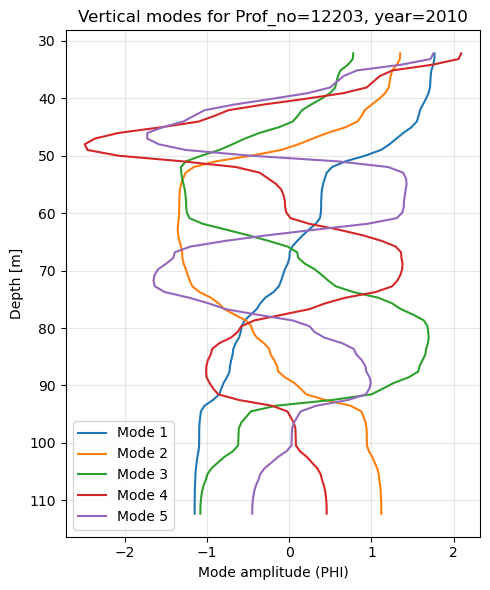

In [12]:
# EVP FOR INDIVIDUAL CAST
# For plotting purposes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

year    = 2010      
prof_no = 12203       
Nm      = 5        # NOT the modes which were calculated, ONLY the modes being plotted 

#ChatGPT Extract said cast from dfN2 
df_year = dfN2.copy()
cast = (
    df_year[df_year["Prof_no"] == prof_no]
    .sort_values("Depth_[m]")
    .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
)

if cast.empty:
    raise ValueError(f"Profile number {prof_no} not found in dfN2 for year {year}.")

# Get native mid-depths and N2 into float
z_mid = cast["Depth_[m]"].to_numpy(float)
N2_mid = cast["N2_[s^-2]"].to_numpy(float)

# Build regular z-grid as in modes_chelt_kelly
dz_native = np.diff(z_mid)
dz_med = float(np.median(dz_native)) if dz_native.size > 0 else np.nan
if not np.isfinite(dz_med) or dz_med <= 0:
    raise ValueError("Invalid dz_med for this cast.")

dz = dz_med
z_reg = np.arange(z_mid.min(), z_mid.max() + 0.5 * dz, dz)
N2_reg = np.interp(z_reg, z_mid, N2_mid)

# Depth grid corresponding to what modes_chelt_kelly actually uses
# (it drops the upper ~30 m internally)
cutoff_depth = 30.0
if cutoff_depth > 0:
    n_cut = int(np.floor(cutoff_depth / dz + 1e-6))
    if n_cut >= z_reg.size:
        raise ValueError(
            f"Profile too shallow to remove upper {cutoff_depth} m "
            f"(z_reg has only {z_reg.size} levels)."
        )
    z_plot = z_reg[n_cut:]   # this matches the length of PHI returned by modes_chelt_kelly
else:
    z_plot = z_reg.copy()

# Solve EVP only for specific cast
PHI, C, PHI2 = modes_chelt_kelly(
    dz=dz,
    N2=N2_reg,
    Nm=Nm,
    include_mode0=False
)

print(f"Computed {len(C)} baroclinic modes (eigenspeeds):")
for i, cval in enumerate(C, start=1):
    print(f"Mode {i}: c_n = {cval:.3f} m/s")

plt.figure(figsize=(5, 6))
for i in range(PHI.shape[1]):
    plt.plot(PHI[:, i], z_plot, label=f"Mode {i+1}")

plt.gca().invert_yaxis()                   # Joke and Friederike...ued in favor of inverting the y-axis. I suppose this is correct?
plt.xlabel("Mode amplitude (PHI)")
plt.ylabel("Depth [m]")
plt.title(f"Vertical modes for Prof_no={prof_no}, year={year}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


The challenge in assesing the credibility of the phase speeds is the small amount of comparable sources online. So far I know only 2 papers and one lecture notes, where only the 2 papers go beyond a phrase like "we expect modes to be around..."

# Actual Arctic Map

In order to have more data points and coherent map parts the QC of 1 or 2 were used, only 0 was omitted.

As Friederike and Joke said, to know what we are dealing with a simple scatter plot is helpful prior to binning and interpolating.

In [96]:
# 0. Load precomputed eigenspeeds/modes from disk so that the later plotting cells know what to work with.
# Saves me the time of perpetually re-writing this line per cell. "Great Sucess" - Borat 

import pandas as pd
from pathlib import Path

MODES_DIR = Path("Modes")

# TUNE THE FILE NAME
modes_file = MODES_DIR / "m_1980-2015_eigencoeffs.txt"

print(f"Loading modes from: {modes_file}")

df_modes = pd.read_csv(modes_file, sep="\t")

# Safety check wrther the time column is available as a proper datetime object
if "time" not in df_modes.columns and "time_str" in df_modes.columns:
    df_modes["time"] = pd.to_datetime(df_modes["time_str"], errors="coerce")

print(f"Loaded {len(df_modes)} rows, "
      f"{df_modes['Prof_no'].nunique()} unique casts.")
print("Columns in df_modes:", df_modes.columns.tolist())


Loading modes from: Modes/m_1980-2015_eigencoeffs.txt
Loaded 143964 rows, 143964 unique casts.
Columns in df_modes: ['year', 'Prof_no', 'time_str', 'lat', 'lon', 'N2_QC_flag', 'dz_used', 'z_min', 'z_max', 'C_mode0', 'C_mode1', 'C_mode2', 'C_mode3', 'time']


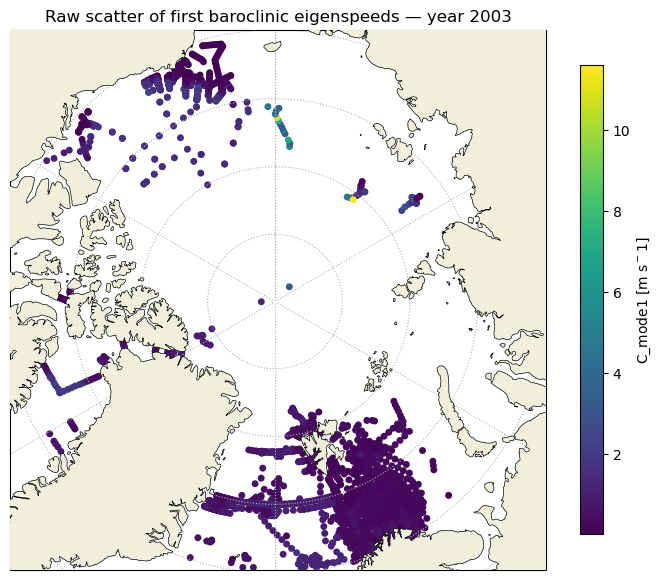

In [102]:
# Simple scatter map of Mode-1 eigenspeed to know what we are dealing with, as Friederike and Joke suggested

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

years_to_plot = list(range(2003, 2004))   # adapt this list/range!!!

mode_index = 1
mode_col = f"C_mode{mode_index}"

# little safety check
if "df_modes" not in globals() or df_modes.empty:
    raise RuntimeError("df_modes is not available. Run the EVP cell / load modes first.")

for year in years_to_plot:
    # Extract all casts for this year 
    df_sc = df_modes[df_modes["year"] == year].copy()
    df_sc = df_sc.dropna(subset=[mode_col])

    # restrict to Arctic, chosen latitude
    df_sc = df_sc[df_sc["lat"] >= 70.0].copy()

    if df_sc.empty:
        print(f"No {mode_col} data for {year}.")
        continue

    # Scatter map 
    # stereographic projection centered on the North Pole
    proj = ccrs.NorthPolarStereo()
    # coordinate reference system of your data (longitude/latitude)
    data_crs = ccrs.PlateCarree()

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection=proj)
    ax.set_extent([-180, 180, 70, 90], crs=data_crs)

    # plot the raw casts as scatter points
    sc = ax.scatter(
        df_sc["lon"],
        df_sc["lat"],
        c=df_sc[mode_col],
        s=25,
        cmap="viridis",
        transform=data_crs,
        zorder=2,
        edgecolors="none"
    )

    # land & coastlines limiting
    ax.add_feature(cfeature.LAND, zorder=3)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=4)
    ax.gridlines(draw_labels=False, linestyle=":", zorder=5)

    cbar = plt.colorbar(sc, ax=ax, shrink=0.7)
    cbar.set_label(f"{mode_col} [m s$^{-1}$]")

    if mode_index == 0:
        mode_name = "barotropic"
    elif mode_index == 1:
        mode_name = "first baroclinic"
    elif mode_index == 2:
        mode_name = "second baroclinic"
    else:
        mode_name = f"mode {mode_index}"

    plt.title(f"Raw scatter of {mode_name} eigenspeeds — year {year}")
    plt.tight_layout()
    plt.show()


Visually this looks close enough to introduce binning and interpolation on at least small scales. In order to interpolate one can define maximal distance limits between measurements, as well as amount of measurements bordering an empty cell, in order to approximate more measurements. With this, patches of coherent data without too much approximations should be producable.

Saved figure: figures_maps/2012_1_eigenspeeds.png


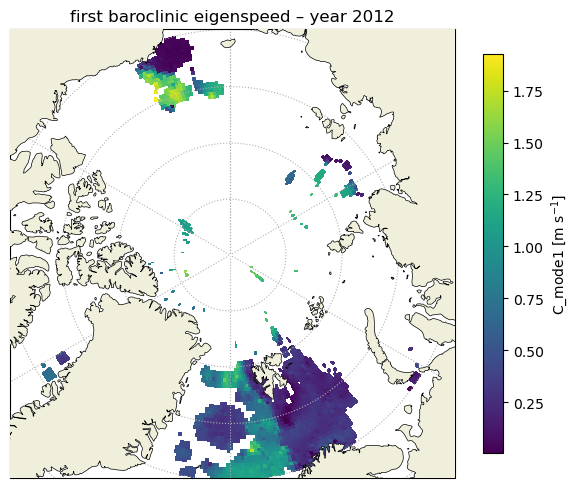

In [103]:
# Binned Lat–lon maps of eigenspeeds for selected years
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path 

years_to_plot = list(range(2012, 2013))   
mode_index = 1           

mode_col = f"C_mode{mode_index}"

if "df_modes" not in globals() or df_modes.empty:
    raise RuntimeError("df_modes is not available. Run the previous cell first.")

FIG_DIR = Path("figures_maps")
FIG_DIR.mkdir(exist_ok=True)


def mask_land_with_bathymetry(C_grid, LAT2, LON2):
    """
    Set C_grid to NaN wherever the grid-cell centre is on land according to
    the IBCAO-based get_bottom_depth() function that I defined earlier
    """
    C_masked = C_grid.copy()
    nlat, nlon = C_masked.shape
    for i in range(nlat):
        for j in range(nlon):
            if not np.isfinite(C_masked[i, j]):
                continue
            depth = get_bottom_depth(LAT2[i, j], LON2[i, j])
            # depth > 0 = ocean in our convention; non-finite or <=0 = land/invalid
            if (not np.isfinite(depth)) or (depth <= 0.0):
                C_masked[i, j] = np.nan
    return C_masked


def fill_small_gaps_neighbour_mean(grid, max_iter=2, min_neighbours=3):
    """
    Iteratively fill NaN cells by averaging their valid 8 neighbours into the empty cell.
    Only fills a cell if it has at least `min_neighbours` finite neighbours.
    """
    g = grid.copy()
    nlat, nlon = g.shape

    for _ in range(max_iter):
        g_new = g.copy()
        changed = False

        for i in range(nlat):
            for j in range(nlon):
                if np.isfinite(g[i, j]):
                    continue  

                # 3x3 neighbourhood around the emopty cell
                i0 = max(i - 1, 0)
                i1 = min(i + 2, nlat)
                j0 = max(j - 1, 0)
                j1 = min(j + 2, nlon)

                neigh = g[i0:i1, j0:j1]
                valid = np.isfinite(neigh)
                n_valid = valid.sum()

                if n_valid >= min_neighbours:
                    g_new[i, j] = np.nanmean(neigh[valid])
                    changed = True

        g = g_new
        if not changed:
            break

    return g   # the grid value


for yr in years_to_plot:
    df_yr = df_modes[df_modes["year"] == yr].copy()

    if df_yr.empty or mode_col not in df_yr.columns:
        print(f"No data or no column {mode_col} for year {yr}.")
        continue

    # Drop casts where mode speed is missing
    df_yr = df_yr.dropna(subset=[mode_col])

    if df_yr.empty:
        print(f"All {mode_col} values are NaN for year {yr}.")
        continue

    # Arctic only for plotting
    df_yr = df_yr[df_yr["lat"] >= 70.0].copy()
    if df_yr.empty:
        print(f"No Arctic casts (lat ≥ 70°N) for year {yr}.")
        continue

    # Binning
    dlat = 0.30   # deg
    dlon = 1.00   # deg
    lat_bins = np.arange(70, 90 + dlat, dlat)
    lon_bins = np.arange(-180, 180 + dlon, dlon)

    # 2D histogram for counts to accumulate them per bin (helpfulö for later cast density)
    H_counts, lat_edges, lon_edges = np.histogram2d(
        df_yr["lat"], df_yr["lon"],
        bins=[lat_bins, lon_bins]
    )

    min_per_bin = 1  

    # initializes empty result grid that will later be filled with values
    C_grid = np.full_like(H_counts, np.nan, dtype=float)

    # digitize indices
    df_yr["lat_bin"] = np.digitize(df_yr["lat"], lat_bins) - 1
    df_yr["lon_bin"] = np.digitize(df_yr["lon"], lon_bins) - 1

    # compute median C per bin, but only where i have enough data
    for (i_lat, i_lon), sub in df_yr.groupby(["lat_bin", "lon_bin"]):
        if (0 <= i_lat < H_counts.shape[0]) and (0 <= i_lon < H_counts.shape[1]):
            if H_counts[i_lat, i_lon] >= min_per_bin:
                C_grid[i_lat, i_lon] = np.nanmedian(sub[mode_col].values)

    # centers of bins for plotting
    lat_centers = 0.5 * (lat_edges[:-1] + lat_edges[1:])
    lon_centers = 0.5 * (lon_edges[:-1] + lon_edges[1:])
    LON2, LAT2 = np.meshgrid(lon_centers, lat_centers)

    # mask out land so colours don't belong to grid cells whose centre is on land
    C_grid = mask_land_with_bathymetry(C_grid, LAT2, LON2)

    # lightly interpolate between neighbouring wet bins
    C_smooth = fill_small_gaps_neighbour_mean(C_grid, max_iter=2, min_neighbours=3)

    # Map with continents and islands from cartopy
    proj = ccrs.NorthPolarStereo()
    data_crs = ccrs.PlateCarree()

    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection=proj)
    ax.set_extent([-180, 180, 70, 90], crs=data_crs)

    
    pcm = ax.pcolormesh(
        LON2,
        LAT2,
        C_smooth,
        transform=data_crs,
        zorder=1,
    )

    #  land/coastlines ON TOP of grid cells, so land visually overlays bordering coloured cells
    ax.add_feature(cfeature.LAND, zorder=3)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=4)

    ax.gridlines(draw_labels=False, linestyle=":", zorder=5)

    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.7)
    cbar.set_label(f"{mode_col} [m s$^{{-1}}$]")

    if mode_index == 0:
        mode_name = "barotropic"
    elif mode_index == 1:
        mode_name = "first baroclinic"
    elif mode_index == 2:
        mode_name = "second baroclinic"
    else:
        mode_name = f"mode {mode_index}"

    plt.title(f"{mode_name} eigenspeed – year {yr}")
    plt.tight_layout()

    fig_name = FIG_DIR / f"{yr}_{mode_index}_eigenspeeds.png"
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    print(f"Saved figure: {fig_name}")

    plt.show()


# 5. Regional Mapping

Since we only have regional coverage, a more focused approach is required. Befor limiting ourselves, and also for later argumentations, a measurement densiry map might be helpful to not just show interpolated results but also more easily highlight regions of interest for each year or a row of years.

Casts in 2012: 3359


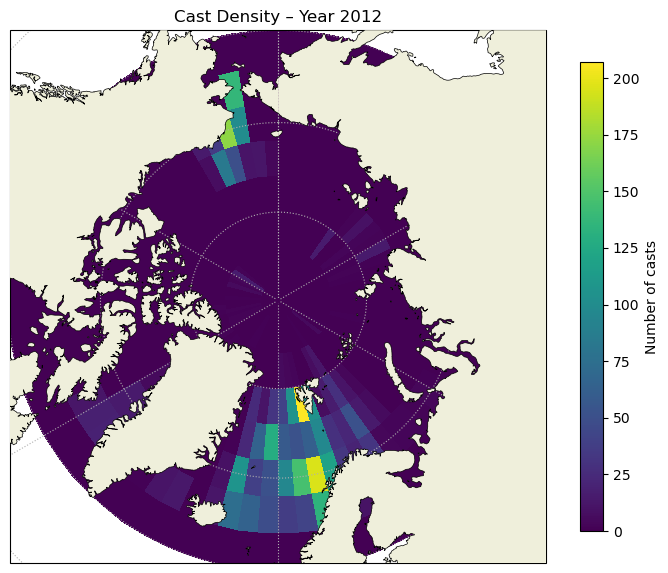

In [104]:
# Cast density map for a SELECTED YEAR

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# choose the years you want to loop through
years_to_plot = list(range(2012, 2013))   # adapt this list/range as you like
# Its already past the year, go one line up

# Safety check cause some cells need to be run every time for some reason
if "df_modes" not in globals() or df_modes.empty:
    raise RuntimeError("df_modes is not available. Run the EVP cell first.")

for year_to_plot in years_to_plot:
    df_den = df_modes[df_modes["year"] == year_to_plot].copy()
    df_den = df_den.dropna(subset=["lat", "lon"])

    if df_den.empty:
        print(f"No casts found in df_modes for year {year_to_plot}")
        continue

    # Choose lat-span
    lat_min = 60.0
    lat_max = 90.0

    df_den = df_den[(df_den["lat"] >= lat_min) & (df_den["lat"] <= lat_max)]

    print(f"Casts in {year_to_plot}: {len(df_den)}")

    # Binning 
    dlat = 4.0   # deg
    dlon = 5.0   # deg
    lat_bins = np.arange(lat_min, lat_max + dlat, dlat)
    lon_bins = np.arange(-180, 180 + dlon, dlon)

    # Creates a 2-D histogram: counts how many points fall into
    H_counts, lat_edges, lon_edges = np.histogram2d(
        df_den["lat"], df_den["lon"],
        bins=[lat_bins, lon_bins]
    )

    # Plot
    lat_centers = 0.5*(lat_edges[:-1] + lat_edges[1:])
    lon_centers = 0.5*(lon_edges[:-1] + lon_edges[1:])
    LON2, LAT2 = np.meshgrid(lon_centers, lat_centers)

    proj = ccrs.NorthPolarStereo()
    data_crs = ccrs.PlateCarree()

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection=proj)
    ax.set_extent([-180, 180, lat_min, lat_max], crs=data_crs)

    pcm = ax.pcolormesh(LON2, LAT2, H_counts, transform=data_crs)
    ax.add_feature(cfeature.LAND, zorder=3)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=4)
    ax.gridlines(draw_labels=False, linestyle=":")

    cbar = plt.colorbar(pcm, ax=ax, shrink=0.7)
    cbar.set_label("Number of casts")

    plt.title(f"Cast Density – Year {year_to_plot}")
    plt.tight_layout()
    plt.show()


Combine them all to find one overarching measurement density projection, this shows us not individual years but one combined plot for all years. For later temporal comparisons this cell here is more important than the previous one.

Total casts in df_modes:        143964
Casts in 60.0°–90.0°N: 143964


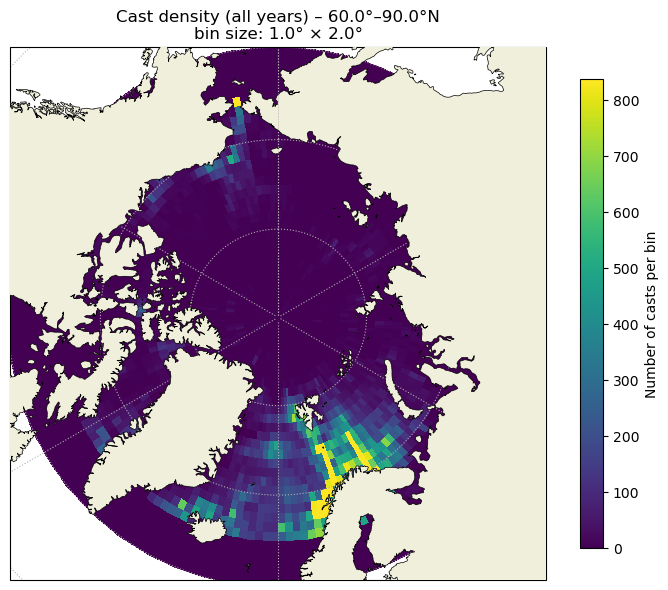


Top 15 densest bins (bin centres and counts):
  # 1: lat ≈  68.5°, lon ≈   13.0°  ->  3292 casts
  # 2: lat ≈  68.5°, lon ≈   15.0°  ->  2843 casts
  # 3: lat ≈  67.5°, lon ≈   13.0°  ->  2748 casts
  # 4: lat ≈  71.5°, lon ≈   19.0°  ->  1536 casts
  # 5: lat ≈  73.5°, lon ≈   19.0°  ->  1487 casts
  # 6: lat ≈  67.5°, lon ≈   11.0°  ->  1486 casts
  # 7: lat ≈  69.5°, lon ≈   33.0°  ->  1432 casts
  # 8: lat ≈  69.5°, lon ≈   17.0°  ->  1401 casts
  # 9: lat ≈  70.5°, lon ≈   19.0°  ->  1380 casts
  #10: lat ≈  74.5°, lon ≈   19.0°  ->  1274 casts
  #11: lat ≈  72.5°, lon ≈   19.0°  ->  1179 casts
  #12: lat ≈  70.5°, lon ≈   31.0°  ->  1114 casts
  #13: lat ≈  65.5°, lon ≈ -169.0°  ->  983 casts
  #14: lat ≈  69.5°, lon ≈   15.0°  ->  946 casts
  #15: lat ≈  71.5°, lon ≈   31.0°  ->  900 casts


In [105]:
# Cast density map over ALL years to see where we actually have data

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
import pandas as pd

# ChatGPT: Check if df_modes exists (I had problems with retrieving the files, so ChatGPT helped me here)
if "df_modes" not in globals() or df_modes.empty:
    MODES_DIR = Path("Modes")
    pattern = "m_*_eigencoeffs.txt"
    modes_files = sorted(MODES_DIR.glob(pattern))

    if not modes_files:
        raise FileNotFoundError(f"No modes files found in {MODES_DIR} matching {pattern}")

    # ChatGPT: small heuristic: prefer a file that spans many years (e.g. 1980-2015)
    def year_span_from_stem(stem):
        parts = stem.split("_")
        if len(parts) < 2:
            return (None, None)
        yr_part = parts[1]
        if "-" in yr_part:
            ys, ye = yr_part.split("-")
        else:
            ys = ye = yr_part
        try:
            return int(ys), int(ye)
        except ValueError:
            return (None, None)

    best_file = None
    best_span = -1
    for f in modes_files:
        ys, ye = year_span_from_stem(f.stem)
        if ys is None or ye is None:
            continue
        span = ye - ys
        if span > best_span:
            best_span = span
            best_file = f

    if best_file is None:
        # fallback: just take the first file
        best_file = modes_files[0]

    print(f"Loading df_modes from: {best_file}")
    df_modes = pd.read_csv(best_file, sep="\t")
    if "time" not in df_modes.columns and "time_str" in df_modes.columns:
        df_modes["time"] = pd.to_datetime(df_modes["time_str"], errors="coerce")

# 1. Basic selection: choose lat/lon 

df_den = df_modes.dropna(subset=["lat", "lon"]).copy()

lat_min = 60.0
lat_max = 90.0

df_den = df_den[(df_den["lat"] >= lat_min) & (df_den["lat"] <= lat_max)]

if df_den.empty:
    raise RuntimeError("No casts in the selected latitude range.")

print(f"Total casts in df_modes:        {len(df_modes)}")
print(f"Casts in {lat_min}°–{lat_max}°N: {len(df_den)}")

# 2. Binning in lat/lon (I am more interested in an overview over what regions are ROI, hence the large bins)

dlat = 1.0   # deg
dlon = 2.0   # deg

lat_bins = np.arange(lat_min, lat_max + dlat, dlat)
lon_bins = np.arange(-180.0, 180.0 + dlon, dlon)

H_counts, lat_edges, lon_edges = np.histogram2d(
    df_den["lat"], df_den["lon"],
    bins=[lat_bins, lon_bins]
)

lat_centers = 0.5 * (lat_edges[:-1] + lat_edges[1:])
lon_centers = 0.5 * (lon_edges[:-1] + lon_edges[1:])
LON2, LAT2 = np.meshgrid(lon_centers, lat_centers)

# 3. Plot the all-years density map 

proj = ccrs.NorthPolarStereo()
data_crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=proj)
ax.set_extent([-180, 180, lat_min, lat_max], crs=data_crs)

# ChatGPT: avoid a single crazy bin blowing up the colour range
if np.any(H_counts > 0):
    vmax = np.nanpercentile(H_counts[H_counts > 0], 99)
else:
    vmax = 1

pcm = ax.pcolormesh(LON2, LAT2, H_counts, transform=data_crs, vmax=vmax)

ax.add_feature(cfeature.LAND, zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=4)
ax.gridlines(draw_labels=False, linestyle=":")

cbar = plt.colorbar(pcm, ax=ax, shrink=0.7)
cbar.set_label("Number of casts per bin")

plt.title(
    f"Cast density (all years) – {lat_min}°–{lat_max}°N\n"
    f"bin size: {dlat}° × {dlon}°"
)
plt.tight_layout()
plt.show()

# 4. Print the densest bins

flat_counts = H_counts.ravel()
flat_indices = np.argsort(flat_counts)[::-1]  

N_top = 15
print(f"\nTop {N_top} densest bins (bin centres and counts):")

shown = 0
for idx in flat_indices:
    count = flat_counts[idx]
    if count <= 0:
        break

    i_lat, i_lon = np.unravel_index(idx, H_counts.shape)
    lat_c = lat_centers[i_lat]
    lon_c = lon_centers[i_lon]

    print(f"  #{shown+1:2d}: lat ≈ {lat_c:5.1f}°, lon ≈ {lon_c:6.1f}°  ->  {int(count)} casts")

    shown += 1
    if shown >= N_top:
        break


# 5. Regional Mapping

Begin by calling modes again, just to have some choice again

In [106]:
# 0. Load precomputed eigenspeeds/modes from disk so that the later plotting cells know what to work with.
# Saves me the time of perpetually re-writing this line per cell. "Great Sucess" - Borat 

import pandas as pd
from pathlib import Path

MODES_DIR = Path("Modes")

# TUNE THE FILE NAME
modes_file = MODES_DIR / "m_1980-2015_eigencoeffs.txt"

print(f"Loading modes from: {modes_file}")

df_modes = pd.read_csv(modes_file, sep="\t")

# Safety check wrther the time column is available as a proper datetime object
if "time" not in df_modes.columns and "time_str" in df_modes.columns:
    df_modes["time"] = pd.to_datetime(df_modes["time_str"], errors="coerce")

print(f"Loaded {len(df_modes)} rows, "
      f"{df_modes['Prof_no'].nunique()} unique casts.")
print("Columns in df_modes:", df_modes.columns.tolist())


Loading modes from: Modes/m_1980-2015_eigencoeffs.txt
Loaded 143964 rows, 143964 unique casts.
Columns in df_modes: ['year', 'Prof_no', 'time_str', 'lat', 'lon', 'N2_QC_flag', 'dz_used', 'z_min', 'z_max', 'C_mode0', 'C_mode1', 'C_mode2', 'C_mode3', 'time']


This cell defines the bins and regional thresholds for regional maps, not running anything explicitely. 
This does not use the same bins as the "All Years Measurement Density" Map, but instead the one from the actual interpolated maps,for accuracy.

In [107]:
import numpy as np

if "df_modes" not in globals() or df_modes.empty:
    raise RuntimeError("df_modes is not available. Run the EVP / load modes cell first.")

# Keep only valid lat/lon and chosen area
df_den_all = df_modes.dropna(subset=["lat", "lon"]).copy()
df_den_all = df_den_all[df_den_all["lat"] >= 70.0]  # same lat-range as your maps

if df_den_all.empty:
    raise RuntimeError("No casts in df_modes with lat ≥ 70°N.")

print(f"Total casts in df_modes: {len(df_modes)}")
print(f"Casts in lat ≥ 70°N:      {len(df_den_all)}")

# MUST use the SAME binning as in the binned eigenspeed maps
dlat_reg = 0.30   # deg
dlon_reg = 1.00   # deg
lat_bins_reg = np.arange(70, 90 + dlat_reg, dlat_reg)
lon_bins_reg = np.arange(-180, 180 + dlon_reg, dlon_reg)

H_counts_reg, lat_edges_reg, lon_edges_reg = np.histogram2d(
    df_den_all["lat"], df_den_all["lon"],
    bins=[lat_bins_reg, lon_bins_reg]
)

lat_centers_reg = 0.5 * (lat_edges_reg[:-1] + lat_edges_reg[1:])
lon_centers_reg = 0.5 * (lon_edges_reg[:-1] + lon_edges_reg[1:])
LON2_reg, LAT2_reg = np.meshgrid(lon_centers_reg, lat_centers_reg)

# CHOOSE threshold for "enough data" over all years in that bin
min_casts_all_years = 1  
REGION_MASK = H_counts_reg >= min_casts_all_years

coverage = np.count_nonzero(REGION_MASK) / REGION_MASK.size
print(f"Bins with ≥{min_casts_all_years} casts (all years): {coverage*100:.1f}% of Arctic grid")

# Save these as globals so the next cell can use them for regional limitatins
REGION_LAT_EDGES = lat_edges_reg
REGION_LON_EDGES = lon_edges_reg
REGION_LAT_CENTERS = lat_centers_reg
REGION_LON_CENTERS = lon_centers_reg
REGION_LON2 = LON2_reg
REGION_LAT2 = LAT2_reg
REGION_COUNTS = H_counts_reg


Total casts in df_modes: 143964
Casts in lat ≥ 70°N:      95387
Bins with ≥1 casts (all years): 24.4% of Arctic grid


In [108]:
# Automatic detection of data-rich regions from the REGION_MASK
# This finds connected blobs of well-sampled bins and creates bounding boxes for them, but without creating a density map and with
# a better resolution.

import numpy as np
from scipy import ndimage

# ChatGPT: safety checks
for name in ["REGION_MASK", "REGION_LON2", "REGION_LAT2"]:
    if name not in globals():
        raise RuntimeError(f"{name} is not defined. Run the data-support mask cell (Cell A) first.")

mask = REGION_MASK.astype(bool)

# 8-neighbour check (also count diagonals as connected)
structure = np.array([[1,1,1],
                      [1,1,1],
                      [1,1,1]], dtype=int)

labels, n_labels = ndimage.label(mask, structure=structure)
print(f"Found {n_labels} connected data-rich blobs in REGION_MASK.")

# Only keeps data regions that are big enough to be meaningful regions
min_bins_per_region = 100   # TUNABLE
AUTO_REGIONS = []          # list of dicts describing each region

for lab in range(1, n_labels + 1):
    region_mask = (labels == lab)
    n_bins = int(region_mask.sum())

    if n_bins < min_bins_per_region:
        continue

    lat_vals = REGION_LAT2[region_mask]
    lon_vals = REGION_LON2[region_mask]

    reg_info = {
        "id": lab,
        "n_bins": n_bins,
        "lat_min": float(lat_vals.min()),
        "lat_max": float(lat_vals.max()),
        "lon_min": float(lon_vals.min()),
        "lon_max": float(lon_vals.max()),
    }
    AUTO_REGIONS.append(reg_info)

# Sort regions by size, so Region_1 is the biggest 
AUTO_REGIONS.sort(key=lambda r: r["n_bins"], reverse=True)

print(f"{len(AUTO_REGIONS)} regions kept with at least {min_bins_per_region} bins.\n")

for i, reg in enumerate(AUTO_REGIONS, start=1):
    print(
        f"Region {i}: {reg['n_bins']} bins  |  "
        f"lat ~ [{reg['lat_min']:.1f}, {reg['lat_max']:.1f}]°, "
        f"lon ~ [{reg['lon_min']:.1f}, {reg['lon_max']:.1f}]°"
    )


Found 451 connected data-rich blobs in REGION_MASK.
4 regions kept with at least 100 bins.

Region 1: 3202 bins  |  lat ~ [70.2, 83.0]°, lon ~ [-25.5, 87.5]°
Region 2: 755 bins  |  lat ~ [70.2, 80.0]°, lon ~ [-179.5, -120.5]°
Region 3: 258 bins  |  lat ~ [74.3, 82.4]°, lon ~ [114.5, 145.5]°
Region 4: 185 bins  |  lat ~ [71.0, 79.1]°, lon ~ [-79.5, -57.5]°


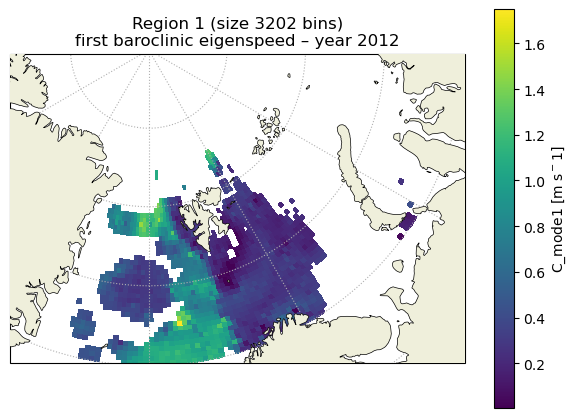

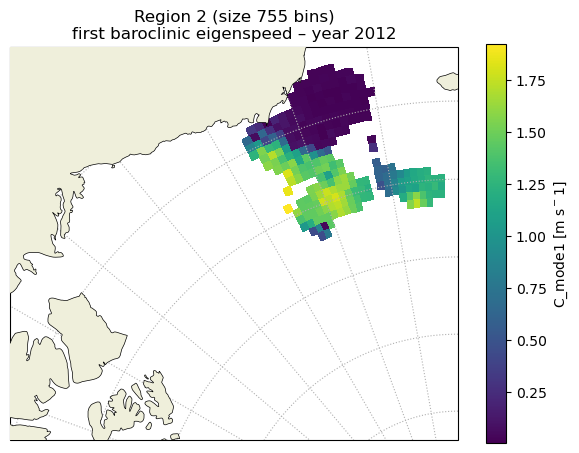

In [109]:
# Regional eigenspeed maps 

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

years_to_plot = list(range(2012, 2013))   # choose years
mode_index = 1                            # choose modes
mode_col = f"C_mode{mode_index}"

# how many of the largest auto-regions to plot
n_regions_to_plot = 2

# sanity checks
if "df_modes" not in globals() or df_modes.empty:
    raise RuntimeError("df_modes is not available. Run the EVP / load modes cell first.")

for name in ["REGION_MASK", "REGION_LAT_EDGES", "REGION_LON_EDGES",
             "REGION_LAT_CENTERS", "REGION_LON_CENTERS",
             "REGION_LON2", "REGION_LAT2", "AUTO_REGIONS"]:
    if name not in globals():
        raise RuntimeError(f"{name} is not defined. Run Cell A and the auto-region cell first.")

if len(AUTO_REGIONS) == 0:
    raise RuntimeError("AUTO_REGIONS is empty. Lower min_bins_per_region or check REGION_MASK.")


def mask_land_with_bathymetry(C_grid, LAT2, LON2):
    """
    Set C_grid to NaN wherever the grid-cell centre is on land according to
    the IBCAO-based get_bottom_depth() function that I defined earlier
    """
    C_masked = C_grid.copy()
    nlat, nlon = C_masked.shape
    for i in range(nlat):
        for j in range(nlon):
            if not np.isfinite(C_masked[i, j]):
                continue
            depth = get_bottom_depth(LAT2[i, j], LON2[i, j])
            # depth > 0 = ocean in our convention; non-finite or <=0 = land/invalid
            if (not np.isfinite(depth)) or (depth <= 0.0):
                C_masked[i, j] = np.nan
    return C_masked


def fill_small_gaps_neighbour_mean(grid, max_iter=2, min_neighbours=3):
    """
    Iteratively fill NaN cells by averaging their valid 8 neighbours.
    Only fills a cell if it has at least `min_neighbours` finite neighbours.
    """
    g = grid.copy()
    nlat, nlon = g.shape

    for _ in range(max_iter):
        g_new = g.copy()
        changed = False

        for i in range(nlat):
            for j in range(nlon):
                if np.isfinite(g[i, j]):
                    continue  

                # 3x3 neighbourhood
                i0 = max(i - 1, 0)
                i1 = min(i + 2, nlat)
                j0 = max(j - 1, 0)
                j1 = min(j + 2, nlon)

                neigh = g[i0:i1, j0:j1]
                valid = np.isfinite(neigh)
                n_valid = valid.sum()

                if n_valid >= min_neighbours:
                    g_new[i, j] = np.nanmean(neigh[valid])
                    changed = True

        g = g_new
        if not changed:
            break

    return g

# same grid as REGION_MASK
lat_bins = REGION_LAT_EDGES
lon_bins = REGION_LON_EDGES
LON2, LAT2 = REGION_LON2, REGION_LAT2

# choose which auto-regions to use (largest n_regions_to_plot)
regions_to_use = AUTO_REGIONS[:n_regions_to_plot]

for yr in years_to_plot:
    df_yr = df_modes[df_modes["year"] == yr].copy()

    if df_yr.empty or mode_col not in df_yr.columns:
        print(f"No data or no column {mode_col} for year {yr}.")
        continue

    df_yr = df_yr.dropna(subset=[mode_col])
    df_yr = df_yr[df_yr["lat"] >= 60.0].copy()  # minimal Arctic cut

    if df_yr.empty:
        print(f"No Arctic casts (lat ≥ 60°N) for year {yr}.")
        continue

    H_counts, _, _ = np.histogram2d(
        df_yr["lat"], df_yr["lon"],
        bins=[lat_bins, lon_bins]
    )

    min_per_bin = 1  # per-year

    # prepare grid for median phase speed
    C_grid_base = np.full_like(H_counts, np.nan, dtype=float)

    # digitize indices
    df_yr["lat_bin"] = np.digitize(df_yr["lat"], lat_bins) - 1
    df_yr["lon_bin"] = np.digitize(df_yr["lon"], lon_bins) - 1

    for (i_lat, i_lon), sub in df_yr.groupby(["lat_bin", "lon_bin"]):
        if (0 <= i_lat < H_counts.shape[0]) and (0 <= i_lon < H_counts.shape[1]):
            if H_counts[i_lat, i_lon] >= min_per_bin:
                C_grid_base[i_lat, i_lon] = np.nanmedian(sub[mode_col].values)

    # one map per automatically detected region
    for i_reg, reg in enumerate(regions_to_use, start=1):
        C_grid = C_grid_base.copy()

        # 1) apply long-term mask
        C_grid[~REGION_MASK] = np.nan

        # 2) apply region-specific bounding box from AUTO_REGIONS
        roi_mask = (
            (LAT2 >= reg["lat_min"]) & (LAT2 <= reg["lat_max"]) &
            (LON2 >= reg["lon_min"]) & (LON2 <= reg["lon_max"])
        )
        C_grid[~roi_mask] = np.nan

        if not np.any(np.isfinite(C_grid)):
            print(f"No supported data in auto-region {i_reg} for year {yr}.")
            continue

        # 3) mask land
        C_grid = mask_land_with_bathymetry(C_grid, LAT2, LON2)

        # 4) light neighbour interpolation inside the data-supported patch
        C_smooth = fill_small_gaps_neighbour_mean(C_grid, max_iter=2, min_neighbours=3)

        # plotting
        proj = ccrs.NorthPolarStereo()
        data_crs = ccrs.PlateCarree()

        fig = plt.figure(figsize=(6, 6))
        ax = plt.axes(projection=proj)

        margin_lat = 0.2
        margin_lon = 0.5
        ax.set_extent(
            [reg["lon_min"] - margin_lon, reg["lon_max"] + margin_lon,
             reg["lat_min"] - margin_lat, reg["lat_max"] + margin_lat],
            crs=data_crs,
        )

        pcm = ax.pcolormesh(
            LON2,
            LAT2,
            C_smooth,
            transform=data_crs,
            zorder=1,
        )

        ax.add_feature(cfeature.LAND, zorder=3)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=4)
        ax.gridlines(draw_labels=False, linestyle=":", zorder=5)

        cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.7)
        cbar.set_label(f"{mode_col} [m s$^{-1}$]")

        if mode_index == 0:
            mode_name = "barotropic"
        elif mode_index == 1:
            mode_name = "first baroclinic"
        elif mode_index == 2:
            mode_name = "second baroclinic"
        else:
            mode_name = f"mode {mode_index}"

        plt.title(
            f"Region {i_reg} (size {reg['n_bins']} bins)\n"
            f"{mode_name} eigenspeed – year {yr}"
        )
        plt.tight_layout()
        plt.show()


# Befor any temporal comparisons are done we MUST deal with the few (less than 500) unphysical outliers being c>2m/s. Then improved regional maps would mazbe help too?